# Module modelling

## Libraries import

In [118]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import pvlib.pvsystem as pvsystem
# deep copy
import copy
# for pvlib
from scipy.optimize import brentq, newton

## Global variables
Beware overlap in irradiance at 0:00

In [56]:
PVSYST_FOLDER = r"C:\Users\wsfm\PVsyst7.0_Data\UserHourly"
# PVsyst project simulation output file


# with old sport data
PVSYST_HOURLY_FILE = r"Project_test_221012_Project_VC0_HourlyRes_spot.csv"
# with replaced average
PVSYST_HOURLY_FILE = r"Project_test_221012_Project_VC0_HourlyRes_250_m10_dummy.csv"
# 26/3/23 power output in W
PVSYST_HOURLY_FILE = r"Project_test_221012_Project_VC4_HourlyRes_250_1m.CSV"

# 175 Sandia pvsyst
"""PVSYST_HOURLY_FILES = [
    "Project_test_221012_Project_VC4_HourlyRes_175_1m_s.csv",
 "Project_test_221012_Project_VC4_HourlyRes_175_1m_snd.csv"]"""
PVSYST_HOURLY_FILES = [PVSYST_HOURLY_FILE]


# PVsyst project exported meteo file
PVSYST_HOURLY_METEO = r"Loughborough_meteo.csv"

CREST_IRRADIANCE_FOLDER = r"C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\model_predict\ground-based-solar-irradiance\assets\isc_irradiance_files"
CREST_IRRADIANCE_FILE = r"chpoa_y15.csv"
#PVSYST_HOURLY_FILE = r"Project_test_221012_Project_VC0_HourlyRes_5 - Copy.csv"

k_Boltzmann = 1.381 / (10 ** 23) # J/K
q_electron = 1.602 / (10 ** 19) # C


PVLS:dict = {"dhi":"DiffHor", "ghi":"GlobHor", "sky_diffuse":"DifITrp", "solar_azimuth":"AzSol",
"temp_air":"T_Amb", "wind_speed":"WindVel",
# TBC
"dni":"BeamHor"
}
# Copy & paste Io should be I0

# wrong are already normalised
# 23/1/23 to be checked
#"dni":"BeamHor", "dni_extra":"Io",


# solar zenith complementary angle than solar elevation

# Spencer 1971, 
# PyEphem package (pvlib.solarposition.pyephem)
# ASCE 2005, ASCE Standardized Reference Evapotranspiration Equation, Environmental and Water Resources Institute of the American Civil Engineers, Ed. R. G. Allen et al.
EXTRA_RADIATION_METHODS = ["spencer"] #,"pyephem","asce","nrel"]
SOLAR_CONSTANT = 1366.1

WEATHER_ANALYSIS = ["retrotransposition","GlobTrp","haydavies","total_irradiance"]

# 26/2/23 total irradiance to be checked again also affecting GlobEff

MODULE_ANALYSIS = ["GlobEff","TArray","IV","IV_PL","IV_SANDIA"]

ANALYSIS = ["IV_CURVES","IV_PL"]
ANALYSIS = WEATHER_ANALYSIS + MODULE_ANALYSIS
run = False

In [57]:
ANALYSIS

['retrotransposition',
 'GlobTrp',
 'haydavies',
 'total_irradiance',
 'GlobEff',
 'TArray',
 'IV',
 'IV_PL',
 'IV_SANDIA']

###  Global variables : pv modules

####  Solar World 175 Mono (E) / SW 175 Mono [PVsyst]
Values seem to correspond:
Isc 5.3
Not available in CEC
Also possibility to try Sandia model in PVsyst

####  Solar World 250 Poly (E) /SW 250 Poly
Different Isc

####  Solar World 245 Poly (E) /SW 245 Poly

In [58]:
pvsyst_Solar_World_SW175_Mono_Sun_Module__2009__E__ = {
#The short-circuit current temperature coefficient of the module in units of A/C.
# muIsc  (often named Alpha)
"alpha_sc" : 3.2 / (10**3), 
#The diode ideality factor # muIsc  (often named Alpha)
"gamma_ref" : 1.010, 
# The temperature coefficient for the diode ideality factor, 1/K
# using 2nd value comparing in the diode ideality factor 
"mu_gamma" : -0.001, 
#The light-generated current (or photocurrent) at reference conditions, in amperes.
# using Isc for I_L_ref
"I_L_ref" :5.3, 
#The dark or diode reverse saturation current at reference conditions, in amperes.
"I_o_ref" : 0.249 / (10 ** 9), 
#The shunt resistance at reference conditions, in ohms.
"R_sh_ref" : 450, 
#The shunt resistance at zero irradiance conditions, in ohms.
"R_sh_0" : 1800, 
#The series resistance at reference conditions, in ohms.
# series model
"R_s" : 0.693, 
#The number of cells connected in series.
"cells_in_series" : 72, 
#The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
"R_sh_exp" : 5.5, 
#The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
"EgRef" : 1.12, #1, 
# Reference irradiance in W/m^2.
"irrad_ref" : 1000, 
"temp_ref" : 25
}


# using same label used in pvlib pvsystem.retrieve_sam('SandiaMod')
pvsyst_SolarWorld_Sunmodule_245_Poly__2013 = {
#The short-circuit current temperature coefficient of the module in units of A/C.
# muIsc  (often named Alpha)
"alpha_sc" : 2.9 / (10**3), 
#The diode ideality factor # muIsc  (often named Alpha)
"gamma_ref" : 0.933, 
# The temperature coefficient for the diode ideality factor, 1/K
# using 2nd value comparing in the diode ideality factor 
"mu_gamma" : -0.001, 
#The light-generated current (or photocurrent) at reference conditions, in amperes.
# using Isc for I_L_ref
"I_L_ref" : 8.490, 
#The dark or diode reverse saturation current at reference conditions, in amperes.
"I_o_ref" : 0.040 / (10 ** 9), 
#The shunt resistance at reference conditions, in ohms.
"R_sh_ref" : 300, 
#The shunt resistance at zero irradiance conditions, in ohms.
"R_sh_0" : 1200, 
#The series resistance at reference conditions, in ohms.
# series model
"R_s" : 0.3, 
#The number of cells connected in series.
"cells_in_series" : 60, 
#The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
# PVsyst: this value is set as default value ... Navigation:  Physical models used > PV Module - Standard one-diode-model >
"R_sh_exp" : 5.5, 
#The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
"EgRef" : 1.12, #1, 
# Reference irradiance in W/m^2.
"irrad_ref" : 1000, 
"temp_ref" : 25
}

pvsyst_SolarWorld_Sunmodule_250_Poly__2013 = copy.deepcopy(pvsyst_SolarWorld_Sunmodule_245_Poly__2013)     
# same: "alpha_sc", "mu_gamma", "R_sh_ref", "R_sh_0", "R_s" ,"cells_in_series"
# same: "R_sh_exp", "irrad_ref", "temp_ref"
pvsyst_SolarWorld_Sunmodule_250_Poly__2013["gamma_ref"] = 0.94
# Immpp 8.120 vs 7.960 but not used
pvsyst_SolarWorld_Sunmodule_250_Poly__2013["I_L_ref"] = 8.640
pvsyst_SolarWorld_Sunmodule_250_Poly__2013["I_o_ref"] = 0.046 / (10 ** 9)
# Open circuit Voc 37.6 vs 37.5 but not used
# R serie apparent 0.47 ohm vs 0.48 ohm but not used
# MuVoc -146 mV / C vs -145 but not used

module_sam = "SolarWorld_Sunmodule_250_Poly__2013"
ps_prms = pvsyst_SolarWorld_Sunmodule_250_Poly__2013

# required for testing SANDIA
module_sam = "Solar_World_SW175_Mono_Sun_Module__2009__E__"
ps_prms = pvsyst_Solar_World_SW175_Mono_Sun_Module__2009__E__

sffs = {"Project_test_221012_Project_VC4_HourlyRes_175_1m_s.csv": "_pvs_pvs",
                "Project_test_221012_Project_VC4_HourlyRes_175_1m_snd.csv": "_pvs_snd"
                }
sffs = {"Project_test_221012_Project_VC4_HourlyRes_250_1m.CSV":""}





# 15/3/23 to be checked if relevant
PVS_u_c = 20 #as in PVsyst   #29 default in pvlib 23/2/23 to be checked
PVS_u_v = 0.0
PVS_eta_m = None #deprecated
PVS_module_eff = 0.1  #\eta_{m} = DC\ power / (POA\ irradiance \times module\ area)
PVS_alpha_absorption = 0.9 
# Alpha  is the absorption coefficient of solar irradiation, i.e. (1 - reflection). The usual value of the Absorption coefficient Alpha is 0.9. It is eventually modifiable in the PV module definition dialog.
PVS_module_area = 1.677





In [59]:
show = False
if show: print(ps_prms) 

#### PVsyst parameters
*.Trp: transposed
*.Inc: incident in coll.plane

### CREST system setup

In [60]:
# PVSYST convention
SURFACE_TILT = 34
SURFACE_AZIMUTH = 0
# PVSYST Loughborough
LATITUDE = -52.7767
LONGITUDE = -1.2
ALTITUDE = 53

# CHECK CONVENTIONS FOR PVLIB: lat, lot

## Functions

#### DIFFERENT CONVENTION BETWEEN PVYST AND PVLIB
For comparison between pvsyst & pvlib modelling see laso the Visio file "PVsyst_modeling".

##### PVLIB
surface_tilt : numeric. Panel tilt from horizontal. [degree]
(e.g. surface facing up = 0, surface facing horizon = 90). SAME FOR PVSYST

surface_azimuth : numeric. Panel azimuth from north. [degree]
The Azimuth convention is defined as degrees
east of north (e.g. North = 0, South=180 East = 90, West = 270).

SAME FOR PVSYST
morning = solar_azimuth < 180
afternoon = solar_azimuth > 180

##### PVSYST
surface_azimuth : numeric. Panel azimuth from SOUTH. [degree]
The Azimuth convention is defined as degrees
WEST of SOUTH (e.g. North = 180, South=0 East = 270, West = 90).

updated 24/1/23, equivalent to
East = -90°, West = +90°, North = + or -180°
https://forum.pvsyst.com/topic/101-how-is-defined-the-plane-orientation/

in pvsyst azimuth goes to 0 when behind the horizon 


Angle with respect to south in the Northern hemisphere, and the North in the Southern Hemisphere (opposite to the Architect's convention, but largely adopted in the Solar Industry). 


In [61]:
def pvl_azm_from_pvs(pvs_azm) : 
    #24/1/23 updated
    return (pvs_azm+540)%360

In [62]:
def get_diffuse_haydavies(surface_tilt, surface_azimuth, dhi, dni, dni_extra, solar_zenith, solar_azimuth,projection_ratio
=None):
    # ground reflected irradiance is not included in this algorithm) 
    # https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.irradiance.haydavies.html

    # surface_tilt (numeric) – Surface tilt angles in decimal degrees. The tilt angle is defined as degrees from horizontal (e.g. surface facing up = 0, surface facing horizon = 90)
    # surface_azimuth (numeric) – Surface azimuth angles in decimal degrees. 
    # The azimuth convention is defined as degrees east of north (e.g. North=0, South=180, East=90, West=270).
    # pvlib modified function adopting PVsyst convention (Navigation:  Physical models used)
    # dhi (numeric) – Diffuse horizontal irradiance in W/m^2.
    # dni (numeric) – Direct normal irradiance in W/m^2.
    if projection_ratio is None:
        # +180 
        cos_tt = pvlib.irradiance.aoi_projection(surface_tilt, surface_azimuth,
                                solar_zenith, solar_azimuth)
        cos_tt = np.maximum(cos_tt, 0)  # GH 526
        cos_solar_zenith = pvlib.irradiance.tools.cosd(solar_zenith)
        Rb = cos_tt / np.maximum(cos_solar_zenith, 0.01745)  # GH 432
        # FMI: to test if anything change
        # Rb = cos_tt / cos_solar_zenith  
    else:
        Rb = projection_ratio

    # Anisotropy Index
    AI = dni / dni_extra

    # these are the () and [] sub-terms of the second term of eqn 7
    term1 = 1 - AI
    term2 = 0.5 * (1 + pvlib.irradiance.tools.cosd(surface_tilt))

    # sky_diffuse = dhi * (AI * Rb + term1 * term2)
    # 29/1/23 fmi modified to get minimum 0 on both terms:
    sky_diffuse = dhi * (np.maximum(AI * Rb,0) + np.maximum(term1 * term2,0))

    #sky_diffuse = np.maximum(sky_diffuse, 0)
    return sky_diffuse

In [63]:
#ISOTROPIC component only for comparison

# PVSYST
# pvs_slc["Kb"] = pvs_slc.apply(lambda x: x["BeamHor"] / x["Io_sin_Hsol"] if x["Io_sin_Hsol"] > 0 else 0, axis=1)
# pvs_slc['DifITrp_clc'] = pvs_slc.apply(lambda x: x["DiffHor"] * ((1-x["Kb"])  *  (1 + pvlib.tools.cosd(SURFACE_TILT)) / 2), axis=1)

# PVLIB
def get_diffuse_haydavies_i(surface_tilt, surface_azimuth, dhi, dni, dni_extra, solar_zenith, solar_azimuth,projection_ratio
=None):
    

    # surface_tilt (numeric) – Surface tilt angles in decimal degrees. The tilt angle is defined as degrees from horizontal (e.g. surface facing up = 0, surface facing horizon = 90)
    # surface_azimuth (numeric) – Surface azimuth angles in decimal degrees. 
    # The azimuth convention is defined as degrees east of north (e.g. North=0, South=180, East=90, West=270).
    # pvlib modified function adopting PVsyst convention (Navigation:  Physical models used)
    # dhi (numeric) – Diffuse horizontal irradiance in W/m^2.
    # dni (numeric) – Direct normal irradiance in W/m^2.
    
    if projection_ratio is None:
        # +180 
        cos_tt = pvlib.irradiance.aoi_projection(surface_tilt, surface_azimuth,
                                solar_zenith, solar_azimuth)
        cos_tt = np.maximum(cos_tt, 0)  # GH 526
        cos_solar_zenith = pvlib.irradiance.tools.cosd(solar_zenith)
        Rb = cos_tt / np.maximum(cos_solar_zenith, 0.01745)  # GH 432
        # FMI: to test if anything change
        # Rb = cos_tt / cos_solar_zenith  
    else:
        Rb = projection_ratio

    # Anisotropy Index
    AI = dni / dni_extra

    # these are the () and [] sub-terms of the second term of eqn 7
    term1 = 1 - AI
    term2 = 0.5 * (1 + pvlib.irradiance.tools.cosd(surface_tilt))

    #sky_diffuse = dhi * (AI * Rb + term1 * term2)
    sky_diffuse = dhi * (term1 * term2)
    sky_diffuse = np.maximum(sky_diffuse, 0)
    return sky_diffuse


In [64]:
#CIRCUMSOLAR component only for comparison

# PVLIB
def get_diffuse_haydavies_c(surface_tilt, surface_azimuth, dhi, dni, dni_extra, solar_zenith, solar_azimuth,projection_ratio
=None):
    
    # surface_tilt (numeric) – Surface tilt angles in decimal degrees. The tilt angle is defined as degrees from horizontal (e.g. surface facing up = 0, surface facing horizon = 90)
    # surface_azimuth (numeric) – Surface azimuth angles in decimal degrees. 
    # The azimuth convention is defined as degrees east of north (e.g. North=0, South=180, East=90, West=270).
    # pvlib modified function adopting PVsyst convention (Navigation:  Physical models used)
    # dhi (numeric) – Diffuse horizontal irradiance in W/m^2.
    # dni (numeric) – Direct normal irradiance in W/m^2.
    
    if projection_ratio is None:
        # +180 
        cos_tt = pvlib.irradiance.aoi_projection(surface_tilt, surface_azimuth,
                                solar_zenith, solar_azimuth)
        cos_tt = np.maximum(cos_tt, 0)  # GH 526
        cos_solar_zenith = pvlib.irradiance.tools.cosd(solar_zenith)
        Rb = cos_tt / np.maximum(cos_solar_zenith, 0.01745)  # GH 432
        # FMI: to test if anything change
        # Rb = cos_tt / cos_solar_zenith  
    else:
        Rb = projection_ratio

    # Anisotropy Index
    AI = dni / dni_extra

    # these are the () and [] sub-terms of the second term of eqn 7
    # term1 = 1 - AI
    # term2 = 0.5 * (1 + pvlib.irradiance.tools.cosd(surface_tilt))

    #sky_diffuse = dhi * (AI * Rb + term1 * term2)
    sky_diffuse = dhi * (AI * Rb)
    sky_diffuse = np.maximum(sky_diffuse, 0)
    return sky_diffuse

In [65]:
def get_aoi_projection(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth):
    # surface_azimuth : numeric. Panel azimuth from north
    return pvlib.irradiance.aoi_projection(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth)

In [66]:
def get_iv(df:pd.DataFrame, ps_prms:dict, calcparams="desoto", calcmpp="singlediode", method="lambertw", ivcurve_pnts=400) -> pd.DataFrame:
    """
    wrap-up function
    :param df:
    :param x: dataframe dictionary
    :param ps_prms: parameters dictionary 
    :param calcparams: "desoto" or "pvsyst"
    :param calcmp: "singlediode", "bishop88"
    :param method: 'lambertw' #, 'newton', or 'brentq'
    :param ivcurve_pnts: 
    :return: df with additional columns (see below). i & v as array for each point.
    """ 
    
    # using the ones from pvsyst instead of pvlib
    temp_cell = "TArray"
    effective_irradiance = "GlobEff"
    # no need to order
    clms_sd = ["photocurrent","saturation_current","resistance_series","resistance_shunt","nNsVth"]
    clms = ["i_sc","v_oc","i_mp","v_mp","p_mp","i_x","i_xx"]
    # 29/3/23 not sorted if single method ?!
    if ivcurve_pnts > 0: clms = clms + ["v","i"]

    if calcparams == "desoto":
        df[clms_sd] = df.apply(
        lambda x:                 
        pvlib.pvsystem.calcparams_desoto(
        effective_irradiance = x[effective_irradiance], 
        temp_cell = x[temp_cell], 
        alpha_sc = ps_prms["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
        a_ref =  ps_prms["gamma_ref"] * ps_prms["cells_in_series"] * k_Boltzmann * 298.16 / q_electron,
        # The product of the usual diode ideality factor (n, unitless), number of cells in series (Ns), and cell thermal voltage at reference conditions, in units of V        
        # {\displaystyle V_{\text{T}}=kT/q,} the thermal voltage.
        # gamma_ref = ps_prms["gamma_ref"], #The diode ideality factor
        # mu_gamma = ps_prms["mu_gamma"], #The temperature coefficient for the diode ideality factor, 1/K
        I_L_ref = ps_prms["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
        I_o_ref = ps_prms["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
        R_sh_ref = ps_prms["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
        # R_sh_0 = ps_prms["R_sh_0"], #The shunt resistance at zero irradiance conditions, in ohms.
        R_s = ps_prms["R_s"], #The series resistance at reference conditions, in ohms.
        # cells_in_series = ps_prms["cells_in_series"], #The number of cells connected in series.
        #R_sh_exp=ps_prms["R_sh_exp"], #The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
        dEgdT= - 0.0002677, #The temperature dependence of the energy bandgap at reference conditions in units of 1/K
        EgRef=ps_prms["EgRef"], #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
        irrad_ref=ps_prms["irrad_ref"], # Reference irradiance in W/m^2.
        temp_ref=ps_prms["temp_ref"] # Reference cell temperature in C.
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms_sd,[np.nan]*len(clms_sd)))), 
        axis=1, result_type='expand')

    # version 0.93, PVsyst v6 model
    elif calcparams == "pvsyst":
        df[clms_sd] = df.apply(lambda x:                 
        pvlib.pvsystem.calcparams_pvsyst(
        effective_irradiance = x[effective_irradiance], 
        temp_cell = x[temp_cell], 
        alpha_sc = ps_prms["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
        gamma_ref = ps_prms["gamma_ref"], #The diode ideality factor
        mu_gamma = ps_prms["mu_gamma"], #The temperature coefficient for the diode ideality factor, 1/K
        I_L_ref = ps_prms["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
        I_o_ref = ps_prms["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
        R_sh_ref = ps_prms["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
        R_sh_0 = ps_prms["R_sh_0"], #The shunt resistance at zero irradiance conditions, in ohms.
        R_s = ps_prms["R_s"], #The series resistance at reference conditions, in ohms.
        cells_in_series = ps_prms["cells_in_series"], #The number of cells connected in series.
        R_sh_exp=ps_prms["R_sh_exp"], #The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
        EgRef=ps_prms["EgRef"], #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
        irrad_ref=ps_prms["irrad_ref"], # Reference irradiance in W/m^2.
        temp_ref=ps_prms["temp_ref"] # Reference cell temperature in C.
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms_sd,[np.nan]*len(clms_sd)))), 
        axis=1, result_type='expand')

    
    if calcmpp == "singlediode":
        df[clms] = df.apply(lambda x:                 
        pvlib.pvsystem.singlediode(
        photocurrent = x["photocurrent"],
        saturation_current = x["saturation_current"],
        resistance_series = x["resistance_series"],
        resistance_shunt = x["resistance_shunt"],
        nNsVth = x["nNsVth"], # k_Boltzmann * x[temp_cell] / q_electron
        ivcurve_pnts = ivcurve_pnts,
        method = method
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms,[np.nan]*len(clms))))
        , axis=1, result_type='expand')
        # not clear why array returned
        df["i_mp"]=df["i_mp"].apply(float)
        df["v_mp"]=df["v_mp"].apply(float)

    # check bishop88 seems the same as single diode
    elif calcmpp == " bishop88":
        # Explicit calculation of points on the IV curve described by the single diode equation.
        clms = ["i_mp","v_mp","p_mp"]
        m = method
        df[clms] =df.apply(lambda x:                 
        pvlib.singlediode.bishop88_mpp(
        photocurrent = x["photocurrent"],
        saturation_current = x["saturation_current"],
        resistance_series = x["resistance_series"],
        resistance_shunt = x["resistance_shunt"],
        nNsVth = x["nNsVth"], # k_Boltzmann * x[temp_cell] / q_electron
        breakdown_factor=0., 
        breakdown_voltage=-5.5,
        breakdown_exp=3.28, 
         ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms,[np.nan]*len(clms))))
        , axis=1, result_type='expand')
        # 19/3/23 value error maybe due to returning variable names, renaming after
        # unecessary same results regardless of the method
        # df.rename(columns=dict(zip(clms,[c+"_bs_"+m[0] for c in clms])), inplace=True)

    return df



In [120]:
ps_prms.keys()

dict_keys(['alpha_sc', 'gamma_ref', 'mu_gamma', 'I_L_ref', 'I_o_ref', 'R_sh_ref', 'R_sh_0', 'R_s', 'cells_in_series', 'R_sh_exp', 'EgRef', 'irrad_ref', 'temp_ref'])

In [67]:
def estimate_voc(photocurrent, saturation_current, nNsVth):
    """
    Rough estimate of open circuit voltage useful for bounding searches for
    ``i`` of ``v`` when using :func:`~pvlib.pvsystem.singlediode`.

    Parameters
    ----------
    photocurrent : numeric
        photo-generated current [A]
    saturation_current : numeric
        diode reverse saturation current [A]
    nNsVth : numeric
        product of thermal voltage ``Vth`` [V], diode ideality factor ``n``,
        and number of series cells ``Ns``

    Returns
    -------
    numeric
        rough estimate of open circuit voltage [V]

    Notes
    -----
    Calculating the open circuit voltage, :math:`V_{oc}`, of an ideal device
    with infinite shunt resistance, :math:`R_{sh} \\to \\infty`, and zero
    series resistance, :math:`R_s = 0`, yields the following equation [1]. As
    an estimate of :math:`V_{oc}` it is useful as an upper bound for the
    bisection method.

    .. math::

        V_{oc, est}=n Ns V_{th} \\log \\left( \\frac{I_L}{I_0} + 1 \\right)

    .. [1] http://www.pveducation.org/pvcdrom/open-circuit-voltage
    """

    return nNsVth * np.log(np.asarray(photocurrent) / saturation_current + 1.0)

In [68]:

def bishop88(diode_voltage, photocurrent, saturation_current,
             resistance_series, resistance_shunt, nNsVth, d2mutau=0,
             NsVbi=np.Inf, breakdown_factor=0., breakdown_voltage=-5.5,
             breakdown_exp=3.28, gradients=False):
    r"""
    Explicit calculation of points on the IV curve described by the single
    diode equation.  Values are calculated as described in [1]_.

    The single diode equation with recombination current and reverse bias
    breakdown is

    .. math::

        I = I_{L} - I_{0} \left (\exp \frac{V_{d}}{nN_{s}V_{th}} - 1 \right )
        - \frac{V_{d}}{R_{sh}}
        - \frac{I_{L} \frac{d^{2}}{\mu \tau}}{N_{s} V_{bi} - V_{d}}
        - a \frac{V_{d}}{R_{sh}} \left (1 - \frac{V_{d}}{V_{br}} \right )^{-m}

    The input `diode_voltage` must be :math:`V + I R_{s}`.


    .. warning::
       * Usage of ``d2mutau`` is required with PVSyst
         coefficients for cadmium-telluride (CdTe) and amorphous-silicon
         (a:Si) PV modules only.
       * Do not use ``d2mutau`` with CEC coefficients.

    Parameters
    ----------
    diode_voltage : numeric
        diode voltage :math:`V_d` [V]
    photocurrent : numeric
        photo-generated current :math:`I_{L}` [A]
    saturation_current : numeric
        diode reverse saturation current :math:`I_{0}` [A]
    resistance_series : numeric
        series resistance :math:`R_{s}` [ohms]
    resistance_shunt: numeric
        shunt resistance :math:`R_{sh}` [ohms]
    nNsVth : numeric
        product of thermal voltage :math:`V_{th}` [V], diode ideality factor
        :math:`n`, and number of series cells :math:`N_{s}` [V]
    d2mutau : numeric, default 0
        PVsyst parameter for cadmium-telluride (CdTe) and amorphous-silicon
        (a-Si) modules that accounts for recombination current in the
        intrinsic layer. The value is the ratio of intrinsic layer thickness
        squared :math:`d^2` to the diffusion length of charge carriers
        :math:`\mu \tau`. [V]
    NsVbi : numeric, default np.inf
        PVsyst parameter for cadmium-telluride (CdTe) and amorphous-silicon
        (a-Si) modules that is the product of the PV module number of series
        cells :math:`N_{s}` and the builtin voltage :math:`V_{bi}` of the
        intrinsic layer. [V].
    breakdown_factor : numeric, default 0
        fraction of ohmic current involved in avalanche breakdown :math:`a`.
        Default of 0 excludes the reverse bias term from the model. [unitless]
    breakdown_voltage : numeric, default -5.5
        reverse breakdown voltage of the photovoltaic junction :math:`V_{br}`
        [V]
    breakdown_exp : numeric, default 3.28
        avalanche breakdown exponent :math:`m` [unitless]
    gradients : bool
        False returns only I, V, and P. True also returns gradients

    Returns
    -------
    tuple
        currents [A], voltages [V], power [W], and optionally
        :math:`\frac{dI}{dV_d}`, :math:`\frac{dV}{dV_d}`,
        :math:`\frac{dI}{dV}`, :math:`\frac{dP}{dV}`, and
        :math:`\frac{d^2 P}{dV dV_d}`

    Notes
    -----
    The PVSyst thin-film recombination losses parameters ``d2mutau`` and
    ``NsVbi`` should only be applied to cadmium-telluride (CdTe) and amorphous-
    silicon (a-Si) PV modules, [2]_, [3]_. The builtin voltage :math:`V_{bi}`
    should account for all junctions. For example: tandem and triple junction
    cells would have builtin voltages of 1.8[V] and 2.7[V] respectively, based
    on the default of 0.9[V] for a single junction. The parameter ``NsVbi``
    should only account for the number of series cells in a single parallel
    sub-string if the module has cells in parallel greater than 1.

    References
    ----------
    .. [1] "Computer simulation of the effects of electrical mismatches in
       photovoltaic cell interconnection circuits" JW Bishop, Solar Cell (1988)
       :doi:`10.1016/0379-6787(88)90059-2`

    .. [2] "Improved equivalent circuit and Analytical Model for Amorphous
       Silicon Solar Cells and Modules." J. Mertens, et al., IEEE Transactions
       on Electron Devices, Vol 45, No 2, Feb 1998.
       :doi:`10.1109/16.658676`

    .. [3] "Performance assessment of a simulation model for PV modules of any
       available technology", André Mermoud and Thibault Lejeune, 25th EUPVSEC,
       2010
       :doi:`10.4229/25thEUPVSEC2010-4BV.1.114`
    """
    # calculate recombination loss current where d2mutau > 0
    is_recomb = d2mutau > 0  # True where there is thin-film recombination loss
    v_recomb = np.where(is_recomb, NsVbi - diode_voltage, np.inf)
    i_recomb = np.where(is_recomb, photocurrent * d2mutau / v_recomb, 0)
    # calculate temporary values to simplify calculations
    v_star = diode_voltage / nNsVth  # non-dimensional diode voltage
    g_sh = 1.0 / resistance_shunt  # conductance
    if breakdown_factor > 0:  # reverse bias is considered
        brk_term = 1 - diode_voltage / breakdown_voltage
        brk_pwr = np.power(brk_term, -breakdown_exp)
        i_breakdown = breakdown_factor * diode_voltage * g_sh * brk_pwr
    else:
        i_breakdown = 0.
    i = (photocurrent - saturation_current * np.expm1(v_star)  # noqa: W503
         - diode_voltage * g_sh - i_recomb - i_breakdown)   # noqa: W503
    v = diode_voltage - i * resistance_series
    retval = (i, v, i*v)
    
    if gradients:
        # calculate recombination loss current gradients where d2mutau > 0
        grad_i_recomb = np.where(is_recomb, i_recomb / v_recomb, 0)
        grad_2i_recomb = np.where(is_recomb, 2 * grad_i_recomb / v_recomb, 0)
        g_diode = saturation_current * np.exp(v_star) / nNsVth  # conductance
        if breakdown_factor > 0:  # reverse bias is considered
            brk_pwr_1 = np.power(brk_term, -breakdown_exp - 1)
            brk_pwr_2 = np.power(brk_term, -breakdown_exp - 2)
            brk_fctr = breakdown_factor * g_sh
            grad_i_brk = brk_fctr * (brk_pwr + diode_voltage *
                                     -breakdown_exp * brk_pwr_1)
            grad2i_brk = (brk_fctr * -breakdown_exp        # noqa: W503
                          * (2 * brk_pwr_1 + diode_voltage   # noqa: W503
                             * (-breakdown_exp - 1) * brk_pwr_2))  # noqa: W503
        else:
            grad_i_brk = 0.
            grad2i_brk = 0.
        grad_i = -g_diode - g_sh - grad_i_recomb - grad_i_brk  # di/dvd
        grad_v = 1.0 - grad_i * resistance_series  # dv/dvd
        # dp/dv = d(iv)/dv = v * di/dv + i
        grad = grad_i / grad_v  # di/dv
        grad_p = v * grad + i  # dp/dv
        grad2i = -g_diode / nNsVth - grad_2i_recomb - grad2i_brk  # d2i/dvd
        grad2v = -grad2i * resistance_series  # d2v/dvd
        grad2p = (
            grad_v * grad + v * (grad2i/grad_v - grad_i*grad2v/grad_v**2)
            + grad_i
        )  # d2p/dv/dvd
        retval += (grad_i, grad_v, grad, grad_p, grad2p)
    return retval

In [69]:
def _get_size_and_shape(args):
    # find the right size and shape for returns
    size, shape = 0, None  # 0 or None both mean scalar
    for arg in args:
        try:
            this_shape = arg.shape  # try to get shape
        except AttributeError:
            this_shape = None
            try:
                this_size = len(arg)  # try to get the size
            except TypeError:
                this_size = 0
        else:
            this_size = arg.size  # if it has shape then it also has size
            if shape is None:
                shape = this_shape  # set the shape if None
        # update size and shape
        if this_size > size:
            size = this_size
            if this_shape is not None:
                shape = this_shape
    return size, shape

In [70]:
def _prepare_newton_inputs(i_or_v_tup, args, v0):
    # broadcast arguments for newton method
    # the first argument should be a tuple, eg: (i,), (v,) or ()
    size, shape = _get_size_and_shape(i_or_v_tup + args)
    if size > 1:
        args = [np.asarray(arg) for arg in args]
    # newton uses initial guess for the output shape
    # copy v0 to a new array and broadcast it to the shape of max size
    if shape is not None:
        v0 = np.broadcast_to(v0, shape).copy()
    return args, v0

In [71]:
def bishop88_mpp(photocurrent, saturation_current, resistance_series,
                 resistance_shunt, nNsVth, d2mutau=0, NsVbi=np.Inf,
                 breakdown_factor=0., breakdown_voltage=-5.5,
                 breakdown_exp=3.28, method='newton'):
    """
    Find max power point.

    Parameters
    ----------
    photocurrent : numeric
        photogenerated current (Iph or IL) [A]
    saturation_current : numeric
        diode dark or saturation current (Io or Isat) [A]
    resistance_series : numeric
        series resistance (Rs) in [Ohm]
    resistance_shunt : numeric
        shunt resistance (Rsh) [Ohm]
    nNsVth : numeric
        product of diode ideality factor (n), number of series cells (Ns), and
        thermal voltage (Vth = k_b * T / q_e) in volts [V]
    d2mutau : numeric, default 0
        PVsyst parameter for cadmium-telluride (CdTe) and amorphous-silicon
        (a-Si) modules that accounts for recombination current in the
        intrinsic layer. The value is the ratio of intrinsic layer thickness
        squared :math:`d^2` to the diffusion length of charge carriers
        :math:`\\mu \\tau`. [V]
    NsVbi : numeric, default np.inf
        PVsyst parameter for cadmium-telluride (CdTe) and amorphous-silicon
        (a-Si) modules that is the product of the PV module number of series
        cells ``Ns`` and the builtin voltage ``Vbi`` of the intrinsic layer.
        [V].
    breakdown_factor : numeric, default 0
        fraction of ohmic current involved in avalanche breakdown :math:`a`.
        Default of 0 excludes the reverse bias term from the model. [unitless]
    breakdown_voltage : numeric, default -5.5
        reverse breakdown voltage of the photovoltaic junction :math:`V_{br}`
        [V]
    breakdown_exp : numeric, default 3.28pv
        avalanche breakdown exponent :math:`m` [unitless]
    method : str, default 'newton'
       Either ``'newton'`` or ``'brentq'``. ''method'' must be ``'newton'``
       if ``breakdown_factor`` is not 0.

    Returns
    -------
    tuple
        max power current ``i_mp`` [A], max power voltage ``v_mp`` [V], and
        max power ``p_mp`` [W]
    """
    # collect args
    args = (photocurrent, saturation_current, resistance_series,
            resistance_shunt, nNsVth, d2mutau, NsVbi, breakdown_factor,
            breakdown_voltage, breakdown_exp)
    # first bound the search using voc
    voc_est = estimate_voc(photocurrent, saturation_current, nNsVth)

    def fmpp(x, *a):
        return bishop88(x, *a, gradients=True)[6]

    if method.lower() == 'brentq':
        # break out arguments for numpy.vectorize to handle broadcasting
        vec_fun = np.vectorize(
            lambda voc, iph, isat, rs, rsh, gamma, d2mutau, NsVbi, vbr_a, vbr,
            vbr_exp: brentq(fmpp, 0.0, voc,
                            args=(iph, isat, rs, rsh, gamma, d2mutau, NsVbi,
                                  vbr_a, vbr, vbr_exp))
        )
        vd = vec_fun(voc_est, *args)
    elif method.lower() == 'newton':
        # make sure all args are numpy arrays if max size > 1
        # if voc_est is an array, then make a copy to use for initial guess, v0
        args, v0 = _prepare_newton_inputs((), args, voc_est)
        vd = newton(
            func=fmpp, x0=v0,
            fprime=lambda x, *a: bishop88(x, *a, gradients=True)[7], args=args
        )
    else:
        raise NotImplementedError("Method '%s' isn't implemented" % method)
    return bishop88(vd, *args)

## Loading & preparing data

Data for pvsyst imported from:
C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\model_predict\ground-based-solar-irradiance\assets\isc_irradiance_files\*.*

In [72]:
crest_irr = pd.read_csv(filepath_or_buffer=os.path.join(CREST_IRRADIANCE_FOLDER,CREST_IRRADIANCE_FILE), 
encoding="utf-8-sig",delimiter=",", encoding_errors="replace") #, usecols=[0,1,2,3,4,5,6]) #nrows=20,

In [73]:
# 22/12/22 UTC false initially to compare with PVsyst
# using date since also in pvsyst
crest_irr["date"] = crest_irr["date_trunc"].apply(lambda x: pd.to_datetime(x, format=r"%d/%m/%Y %H:%M:%S", utc=False))

In [74]:
crest_irr["year"] = crest_irr["date"].dt.year

In [75]:
# reading meteo data
pvs_mt = pd.read_csv(filepath_or_buffer=os.path.join(os.getcwd().replace("examples","data"),PVSYST_HOURLY_METEO), 
encoding="utf-8-sig",delimiter=";", encoding_errors="replace", usecols=[0,1,2,3,4,5,6]) #nrows=20,
pvs_mt["Interval beginning"] = pvs_mt["Interval beginning"].apply(lambda x: pd.to_datetime(x, format=r"%d/%m/%y %H:%M", utc=False))
pvs_mt.rename(columns={"Interval beginning":"date"}, inplace=True)
pvs_mt["Io_sin_Hsol"] = pvs_mt.apply(lambda x: 0 if x["KT"] == 0 else x["GlobHor"]/x["KT"], axis=1)
# Direct normal irradiance (DNI or BeamNor)  are also available for concentrating systems.

In [76]:
# reading output data
# C:\Users\wsfm\PVsyst7.0_Data\Models

# Project_test_definitions_230115
# Project_test_221012_Project_VC0_HourlyRes_9
columns = ["date","GlobInc","GlobEff","EArrRef","EArrMPP","IArray","UArray","EArray","EOutInv","E_Grid","Yr","PR","Lc",
"EffInvR","GlobHor","DiffHor","BeamHor","HSol","AzSol","BeamTrp","DifITrp","CircTrp","HBndTrp","AlbTrp","GlobTrp",
"GincThr","DifSInc","Alb_Inc","CircInc","T_Amb","WindVel"]

#Project_test_definitions_230222
columns += ["TArray","TArrWtd","DTArr","DTArrGl"]
columns += ["EffArrR","EffArrC","EffSysR","EffSysC"]



# TArrWtd: Module Temper. weighted by GlobInc
# DTArrGl: DTArr weighted by "effective" incident Global

#7/1/23: module/energy values to be added for comparison with pvlib

# encoding errors due to units values




### Reading pvsyst data

In [77]:
pvss = {}
pvs_slcs = {}
# 20/3/23 for standard analysis only first file will be considered

for f in PVSYST_HOURLY_FILES:
    # f = PVSYST_HOURLY_FILE
    pvs_out = pd.read_csv(filepath_or_buffer=os.path.join(PVSYST_FOLDER,f), encoding="utf-8-sig",
    skiprows=10,   delimiter=",", encoding_errors="replace") #nrows=20,
    pvs_out = pvs_out.iloc[1:]
    for c in pvs_out.columns.to_list():
        if c != "date": 
            pvs_out[c] = pvs_out[c].astype(float)
    # PVsyst use local time
    # https://forum.pvsyst.com/topic/175-time-zone-in-met-data-file-and-site-file/
    pvs_out["date"] = pvs_out["date"].apply(lambda x: pd.to_datetime(x, format=r"%d/%m/%y %H:%M", utc=False))

    #MERGING DATAFRAMES

    # merging to get solar elevation for extracting I0
    # using out as base since mt has only up to decimal
    pvs_mt_mrg_columns = ["date"]+[c for c in pvs_mt.columns.to_list() if c not in pvs_out.columns.to_list()]

    # different merging to check df well aligned
    # pvs_out_mrg_columns2 = [c for c in pvs_out.columns.to_list()]

    pvs = pvs_out.merge(pvs_mt.loc[:,pvs_mt_mrg_columns], left_on="date", right_on="date", how="left", suffixes=('_x', '_y'))

    # merging for comparison
    pvs = pvs.merge(crest_irr[["g_cmp11_ppuk","date"]], left_on="date", right_on="date")

    pvs.rename(columns={"date":"datetime"}, inplace=True)
    pvs["year"] = pvs["datetime"].dt.year
    pvs["date"] = pvs["datetime"].dt.date
    pvs["hour"] = pvs["datetime"].dt.hour
    # test day previously selected
    pvss[f] = pvs
    pvs_slc = pvs.loc[(pvs["datetime"].dt.day==22) & (pvs["datetime"].dt.month==3),:].copy(deep=True)
    pvs_slcs[f] = pvs_slc


## Modeling analysis & comparison for PVsyst & PVlib: weather data

Ideal option for comparison: create procedure including different step and check when diverging. If difference too much for a step use pvsyst values instead

###  Analysis: retrotransposition
https://forum.pvsyst.com/topic/1041-irradiation-horizontal-or-in-plane/

Last graph shows that retrotransposition of pvsyst loses part at the middle of the 
Inverted Hay model missing upper part. GlobTrp (transposed) as GlobInc (incident)

In [78]:
if "retrotransposition" in ANALYSIS: run = True

In [79]:
run = True
if run:
    pvs["meas_vs_hay"]=pvs.apply(lambda x: x["g_cmp11_ppuk"]-x["GlobInc"], axis=1)

In [80]:
# max rather than min 
if run:
    pvs.loc[pvs["meas_vs_hay"]==np.nanmax(pvs["meas_vs_hay"]), ["date","meas_vs_hay","g_cmp11_ppuk","GlobInc"]]

In [81]:
# sent to Tom on 6/1/23
# pvs.to_csv(os.path.join(r"C:\Users\wsfm\OneDrive - Loughborough University\Downloads","PVsyst_g_cmp11_ppuk_vs_GlobInc_2015.csv"))

In [82]:
# 29/12/22 to be solved
# pvs.loc[pvs["meas_vs_hay"],["date","hour","datetime","meas_vs_hay"]].groupby(by="hour").agg(len)
#.groupby(["date"]).agg(len)
#.sort_values(["meas_vs_hay"], ascending=False)
#.groupby(["date"]).agg(len)

In [83]:
if run:
   pvs.groupby(by="hour").agg({"meas_vs_hay":["min","max",np.mean,np.std]})

In [84]:
if run:
    pvs_slc_clms = ["g_cmp11_ppuk","GlobInc","GlPMeas"]
    pvs_slc = pvs.loc[(pvs["datetime"].dt.day==22) & (pvs["datetime"].dt.month==3),:].copy(deep=True)

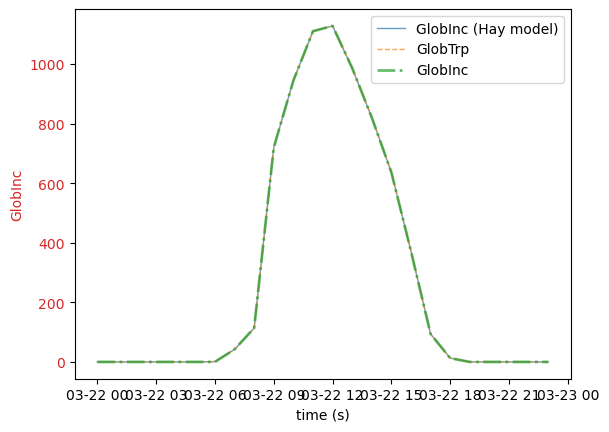

In [85]:
# showing GlobInc (Hay model) = GlobTrp = GlobInc
if run:
    pvs_slc_clms = ["GlobInc (Hay model)",'GlobTrp','GlobInc']
    linestyles = ["-","--","-."]
    linewidths = [1,1,2]

    #pvs["DifI_CircT_Trp"] = pvs["DifITrp"]+pvs["CircTrp"]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('GlobInc', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
     
    plt.show()

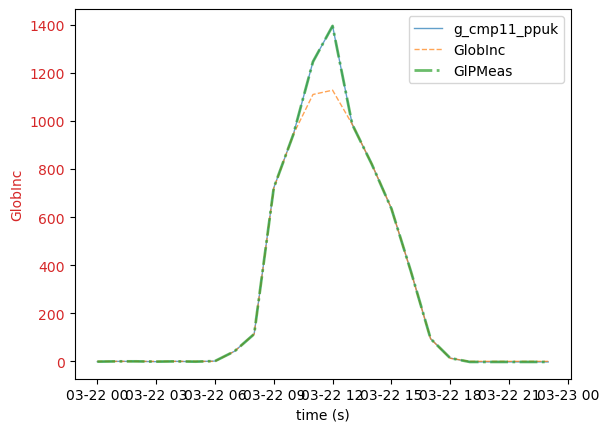

In [86]:
if run:
    # showing retrotransposition failed to achieve previous values
    pvs_slc_clms = ["g_cmp11_ppuk","GlobInc","GlPMeas"] #,"GlobInc (Hay model)",'GlobTrp']
    linestyles = ["-","--","-."] #,":","--"]
    linewidths = [1,1,2] #,2,1]

    #pvs["DifI_CircT_Trp"] = pvs["DifITrp"]+pvs["CircTrp"]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('GlobInc', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()


    """ax2_clmns = ["GlPMeas"]
    # Io quite equal
    # ax2_clmns = ["dni_extra_"+method,"Io"]

    ax2 = ax1.twinx()  
    for c in ax2_clmns:
        ax2.plot(pvs_slc["date"],pvs_slc[c], label=c, color="k")

    color = 'tab:blue'
    ax2.set_ylabel(ax2_clmns[0], color="k")  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor="k")
    ax2.legend()"""

    plt.show()

In [87]:
run = False

###  Analysis: "GlobTrp" (calculation)
Analysing how GlobTrp (which in retrotransposition analysis is equal to GlobInc & GlobHayModel) is calculated

GlobTrp is the sum of BeamTrp, DiFITrp (isotropic), AlbTrp & CircTrp(Circumsolar). 

Expectedly also HbndTrp but no confirmation since equal to 0

In [88]:
if "GlobTrp" in ANALYSIS: run = True

      BeamTrp   DifITrp  AlbTrp  CircTrp  HBndTrp
1910   0.0111    1.0052  0.0189   0.0001      0.0
1911   1.0770   40.1380  0.7643   0.1638      0.0
1912   4.7622  105.6800  2.0413   1.1470      0.0


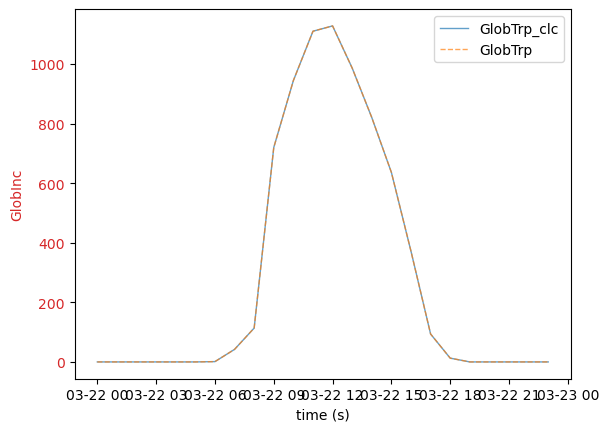

In [89]:
if run:
    pvs_slc['GlobTrp_clc'] = pvs_slc['BeamTrp'] + pvs_slc['DifITrp'] +pvs_slc['AlbTrp'] + pvs_slc["CircTrp"] + pvs_slc["HBndTrp"]
    linestyles = ["-","--"]
    linewidths = [1,1]

    #pvs["DifI_CircT_Trp"] = pvs["DifITrp"]+pvs["CircTrp"]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in ["GlobTrp_clc","GlobTrp"]:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('GlobInc', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()

    print(pvs_slc[['BeamTrp','DifITrp','AlbTrp',"CircTrp","HBndTrp"]].iloc[6:9,:])

In [90]:
run = False

### Analysis - comparison of haydavies (diffuse) transposition between pvlib and pvsyst
Solar position algorithm seemed different (discussion with TB & PI on 23/1/23) so same input spa used. Just checking transposition.

Transposition for sky diffuse gives same results

Retrotrasposition
https://forum.pvsyst.com/topic/1041-irradiation-horizontal-or-in-plane/


#### Manually calculating DiffInc (not used anymore)

PVsyst formulation

The Diffuse component is supposed to be mainly constituted of an isotropic distribution,  and a circum-solar contribution proportional to Kb

DiffInc  = DiffHor *  [  (1-Kb)  *  (1 + cos i) / 2  +  Kb * sin HsolI / sin Hsol ]

Kb    = Clearness index of beam =  BeamHor / (Io * Sin Hsol)

In [91]:
if ("haydavies" in ANALYSIS) or ("GlobEff" in ANALYSIS): 
    # extraradiation required later for GlobEff

    # calculating parameters for irradiance testing
    method = "spencer"
    # epoch year not necessarey
    pvs_slc["dni_extra_"+method] = pvs_slc.apply(lambda x: pvlib.irradiance.get_extra_radiation(x["date"], 
        solar_constant=SOLAR_CONSTANT, method=method, epoch_year=x["year"]), axis=1)

In [92]:
if ("haydavies" in ANALYSIS): run = True

In [93]:
if run:


    pvs_slc["solar_zenith"] = pvs_slc["HSol"].apply(lambda x: 90 - x)
    pvs_slc["solar_azimuth"] = pvs_slc["AzSol"].apply(lambda x: pvl_azm_from_pvs(x))

    pvs_slc["aoi"] = pvs_slc.apply(lambda x: pvlib.irradiance.aoi(SURFACE_TILT, pvl_azm_from_pvs(SURFACE_AZIMUTH),x["solar_zenith"], x["solar_azimuth"]), axis=1)

    # Calculates the dot product of the sun position unit vector and the surface normal unit vector; in other words, the cosine of the angle of incidence
    pvs_slc["aoi_projection"] = pvs_slc.apply(lambda x: get_aoi_projection(SURFACE_TILT, pvl_azm_from_pvs(SURFACE_AZIMUTH),
    x["solar_zenith"], x["solar_azimuth"]), axis=1)

# not used anymore Kb for manual isotropic and circumsolar
# difference between dni_extra & Io_sin_Hsol not so relevant
test = False
if test:
    pvs_slc["Kb"] = pvs_slc.apply(lambda x: x["BeamHor"] / x["Io_sin_Hsol"] if x["Io_sin_Hsol"] > 0 else 0, axis=1)



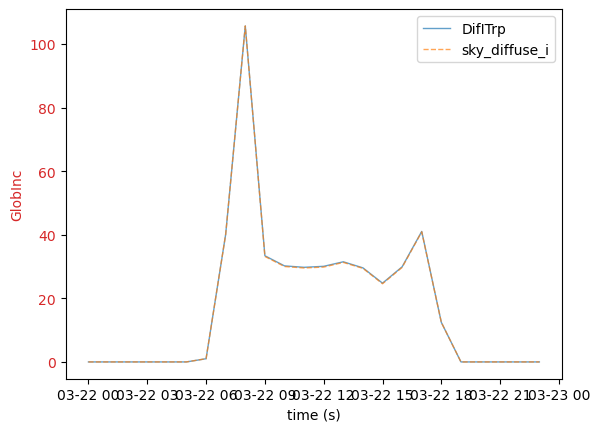

In [94]:
# comparison of isotropic only

#not used anymore
test= False
if test:
    pvs_slc['DifITrp_clc'] = pvs_slc.apply(lambda x: x["DiffHor"] * ((1-x["Kb"])  *  (1 + pvlib.tools.cosd(SURFACE_TILT)) / 2), axis=1)


if run:
    pvs_slc["sky_diffuse_i"] = pvs_slc.apply(lambda x: 
    get_diffuse_haydavies_i(surface_tilt=SURFACE_TILT, surface_azimuth=pvl_azm_from_pvs(SURFACE_AZIMUTH), dhi=x[PVLS["dhi"]], 
    dni=x[PVLS["dni"]], dni_extra=x["Io_sin_Hsol"], solar_zenith=x["solar_zenith"], 
    solar_azimuth=x["solar_azimuth"],projection_ratio=None) if x["Io_sin_Hsol"] > 0 else 0, axis=1)

    pvs_slc_clms = ['DifITrp','sky_diffuse_i']
    linestyles = ["-","--"] #,"-.",":"]
    linewidths = [1,1] #,1,1]
    #"DifSInc","DifI_Circ_HBndTrp"]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('GlobInc', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
    plt.show()

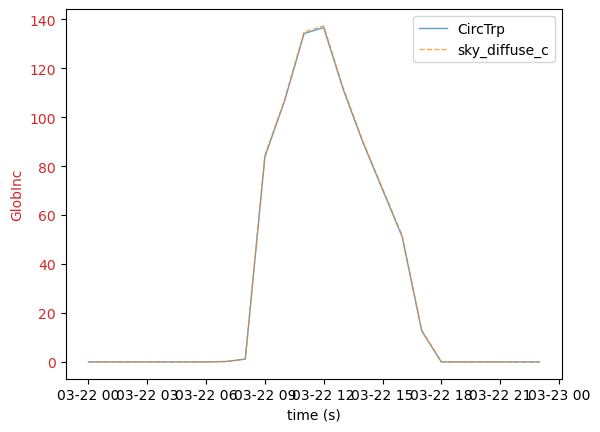

In [95]:
# comparison of isotropic only

# not used anymore
test = False
if test:
    pvs_slc['CircTrp_clc'] = pvs_slc.apply(lambda x: x["DiffHor"] * x["Kb"] * 
    pvlib.tools.sind(90-x["aoi"])/pvlib.tools.sind(x["HSol"]) if x["HSol"]>0 else 0, axis=1)
    
if run:
    pvs_slc["sky_diffuse_c"] = pvs_slc.apply(lambda x: 
    get_diffuse_haydavies_c(surface_tilt=SURFACE_TILT, surface_azimuth=pvl_azm_from_pvs(SURFACE_AZIMUTH), dhi=x[PVLS["dhi"]], 
    dni=x[PVLS["dni"]], dni_extra=x["Io_sin_Hsol"], solar_zenith=x["solar_zenith"], 
    solar_azimuth=x["solar_azimuth"],projection_ratio=None) if x["Io_sin_Hsol"] > 0 else 0, axis=1)

    pvs_slc_clms = ['CircTrp','sky_diffuse_c']
    linestyles = ["-","--"] #,"-.",":"]
    linewidths = [1,1] #,1,1]
    #"DifSInc","DifI_Circ_HBndTrp"]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('GlobInc', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
    plt.show()

In [96]:
if run: print(", ".join(pvs_slc.columns.to_list()))

datetime, GlobInc, GlobEff, EArrRef, EArrMPP, IArray, UArray, EArray, EOutInv, E_Grid, Yr, PR, Lc, EffInvR, GlobHor, DiffHor, BeamHor, HSol, AzSol, AngInc, AngProf, BeamTrp, DifITrp, CircTrp, HBndTrp, AlbTrp, GlobTrp, GincThr, DifSInc, Alb_Inc, CircInc, T_Amb, WindVel, TArray, TArrWtd, DTArr, DTArrGl, EffArrR, EffArrC, EffSysR, EffSysC, BeamNor, GlPMeas, GlobInc (Hay model), KT, Io_sin_Hsol, g_cmp11_ppuk, year, date, hour, meas_vs_hay, GlobTrp_clc, dni_extra_spencer, solar_zenith, solar_azimuth, aoi, aoi_projection, sky_diffuse_i, sky_diffuse_c


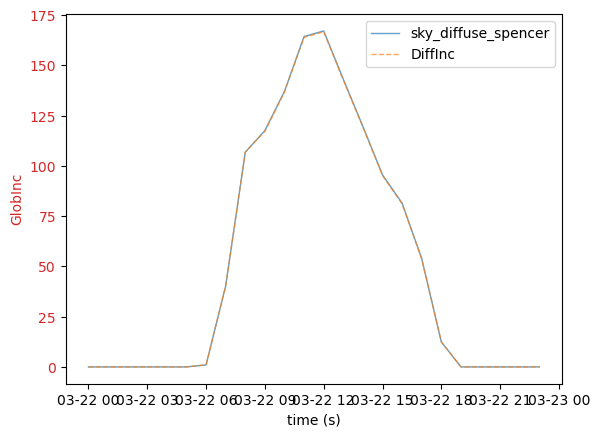

In [97]:
if run:    
    pvs_slc["sky_diffuse_"+method] = pvs_slc.apply(lambda x: 
    get_diffuse_haydavies(surface_tilt=SURFACE_TILT, surface_azimuth=pvl_azm_from_pvs(SURFACE_AZIMUTH), dhi=x[PVLS["dhi"]], 
    dni=x[PVLS["dni"]], dni_extra=x["Io_sin_Hsol"], solar_zenith=x["solar_zenith"], 
    solar_azimuth=x["solar_azimuth"],projection_ratio=None) if x["Io_sin_Hsol"] > 0 else 0, axis=1)


    # The Diffuse component in pvsyst is supposed to be constituted of an isotropic distribution,  and a circum-solar contribution proportional to Kb
    pvs_slc['DiffInc'] = pvs_slc['DifITrp'] + pvs_slc['CircTrp'] # + pvs_slc['AlbTrp'] + pvs_slc["HBndTrp"]

    pvs_slc_clms = ["sky_diffuse_spencer","DiffInc"] #DifI_Circ","DifSInc","DifITrp"]
    linestyles = ["-","--"] #,"-.",":"]
    linewidths = [1,1] #,1,1]
    #"DifSInc","DifI_Circ_HBndTrp"]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('GlobInc', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
    plt.show()

In [98]:
run = False

### Analysis: total_irradiance
27/2/23 incident beam values quite different, other diffuse to be checked

In [99]:
if ("total_irradiance" in ANALYSIS) or ("GlobEff" in ANALYSIS): run = True

In [100]:
exss = []
crts = []

if run:
        clms = ["apparent_zenith","zenith","apparent_elevation","elevation","azimuth","equation_of_time"]

        if any([clms not in pvs_slc.columns.to_list()]):    
                for c in clms: exss.append(c) if c in pvs_slc.columns.to_list() else crts.append(c)

                pvs_slc[clms] = pvs_slc.apply(
                lambda x: pvlib.solarposition.get_solarposition(
                                time= x["datetime"],
                                latitude = LATITUDE,
                                longitude = LONGITUDE,
                                altitude = ALTITUDE,
                                temperature= x[PVLS["temp_air"]], #temperature=weather["temp_air"],
                                pressure=pvlib.atmosphere.alt2pres(ALTITUDE)).values[0], axis=1, result_type='expand')

        elif all([clms not in pvs_slc.columns.to_list()]): 
                for c in clms: 
                        exss.append(c) 
                
        # solar_zenith
        c = "airmass"
        if c not in pvs_slc.columns.to_list(): 
                pvs_slc[c] = pvs_slc['apparent_zenith'].apply(lambda x: pvlib.atmosphere.get_relative_airmass(x))
                crts.append(c)

        elif c in pvs_slc.columns.to_list(): exss.append(c) 

        c = "pressure"
        if c not in pvs_slc.columns.to_list(): 
                pvs_slc[c] = pvlib.atmosphere.alt2pres(ALTITUDE)
                crts.append(c)

        elif c in pvs_slc.columns.to_list(): exss.append(c) 

         
        c = "am_abs"
        if c not in pvs_slc.columns.to_list(): 
                # system['surface_tilt'], system['surface_azimuth'],  solpos["apparent_zenith"], solpos["azimuth"],
                pvs_slc[c] = pvs_slc.apply(lambda x: pvlib.atmosphere.get_absolute_airmass(x["airmass"], x["pressure"]), axis=1)
                crts.append(c)
        
        elif c in pvs_slc.columns.to_list(): exss.append(c) 
     
        c = "aoi"
        # aoi already existing due to previously: 
        # pvs_slc["aoi"] = pvs_slc.apply(lambda x: pvlib.irradiance.aoi(SURFACE_TILT, pvl_azm_from_pvs(SURFACE_AZIMUTH),x["solar_zenith"], x["solar_azimuth"]), axis=1)
        # 30/1/23 why apparent zenith to be used ?
        if c not in pvs_slc.columns.to_list(): 
                # 7/1/23 latitude & longitude pvlib vs pvsyst to be adpated ?
                pvs_slc[c] = pvs_slc.apply(lambda x: pvlib.irradiance.aoi(
                        SURFACE_TILT, 
                        pvl_azm_from_pvs(SURFACE_AZIMUTH),
                        x["zenith"],    #x["apparent_zenith"],
                        x["azimuth"]), axis=1)
                crts.append(c)
        
        elif c in pvs_slc.columns.to_list(): exss.append(c) 


        clms = ['poa_global', 'poa_direct', 'poa_diffuse', 'poa_sky_diffuse', 'poa_ground_diffuse']

        if any([clms not in pvs_slc.columns.to_list()]):    
                for c in clms: exss.append(c) if c in pvs_slc.columns.to_list() else crts.append(c)
                # 15/1/23 total irradiance is dictionary/series
                # 7/1/23 total irradiance expected smaller than POA measured due to Hay inverted
                pvs_slc[clms] = pvs_slc.apply(
                        lambda x: pvlib.irradiance.get_total_irradiance(
                        SURFACE_TILT, 
                        pvl_azm_from_pvs(SURFACE_AZIMUTH),
                        x["zenith"], #x["apparent_zenith"], 
                        x["azimuth"],
                        x[PVLS["dni"]], 
                        x[PVLS["ghi"]],
                        x[PVLS["dhi"]],
                        dni_extra=x["dni_extra_"+method] * pvlib.tools.cosd(x["apparent_zenith"]),
                        model="haydavies"
                        ), axis=1, result_type='expand')
        
        elif all([clms not in pvs_slc.columns.to_list()]): 
                for c in clms: 
                        exss.append(c)

print("Existing: "+", ".join(exss)+"\n"+"Created: "+", ".join(crts))

Existing: aoi
Created: apparent_zenith, zenith, apparent_elevation, elevation, azimuth, equation_of_time, airmass, pressure, am_abs, poa_global, poa_direct, poa_diffuse, poa_sky_diffuse, poa_ground_diffuse


In [101]:
if run:
    print(pvs_slc[['poa_global', 'poa_direct', 'poa_diffuse', 'poa_sky_diffuse', 'poa_ground_diffuse']])

      poa_global  poa_direct  poa_diffuse  poa_sky_diffuse  poa_ground_diffuse
1904    0.000000    0.000000     0.000000         0.000000            0.000000
1905    0.000000    0.000000     0.000000         0.000000            0.000000
1906    0.000000    0.000000     0.000000         0.000000            0.000000
1907    0.000000    0.000000     0.000000         0.000000            0.000000
1908    0.000000    0.000000     0.000000         0.000000            0.000000
1909    0.000000    0.000000     0.000000         0.000000            0.000000
1910    1.029044    0.000000     1.029044         1.005387            0.023657
1911   41.026518    0.001736    41.024782        40.069379            0.955402
1912  108.125700    0.049569   108.076130       105.524516            2.551614
1913   49.969833   10.708453    39.261380        29.089115           10.172264
1914   61.318039   19.089021    42.229018        29.037129           13.191888
1915   73.208578   25.973020    47.235558        31.

In [102]:
run = False

## Modeling analysis & comparison for PVsyst & PVlib: module data
Ideal option for comparison: create procedure including different step and check when diverging. If difference too much for a step use pvsyst values instead

Various functions are defined in pvlib to calculate parameters according to pvsyst

**temperature.pvsyst_cell(poa_global, temp_air)**
Calculate cell temperature using an empirical heat loss factor model as implemented in PVsyst.

**pvsystem.calcparams_pvsyst(…[, R_sh_exp, …])**
Calculates five parameter values for the single diode equation at effective irradiance and cell temperature using the PVsyst v6 model.

*The five values returned by calcparams_pvsyst can be used by singlediode to calculate an IV curve.*

**pvsystem.singlediode(photocurrent, …[, …])**
Solve the single-diode equation to obtain a photovoltaic IV curve.

**ivtools.sdm.pvsyst_temperature_coeff(…[, …])**
Calculates the temperature coefficient of power for a pvsyst single diode model.

**pvsystem.dc_ohms_from_percent(vmp_ref, …)**
Calculates the equivalent resistance of the wires from a percent ohmic loss at STC.

**pvsystem.dc_ohmic_losses(resistance, current)**
Returns ohmic losses in units of power from the equivalent resistance of the wires and the operating current.

See also:
https://pvlib-python.readthedocs.io/en/v0.9.0/api.html?highlight=pvsyst#pvsyst-model

### PVlib system configuration
See also:
https://pvlib-python.readthedocs.io/en/stable/user_guide/pvsystem.html#pvsystem-and-arrays

In [103]:
#if any(a for a in ANALYSIS if a in MODULE_ANALYSIS): 
if "IV_SANDIA" in ANALYSIS: 
          
     # calculating parameters for module testing

     # system parameter could be taken from setup
     # dictionary to find correspondance with pvlib if necessary (not if calculated & comparison after)
     # beware that since reverted HayDavies smaller irradiance than measured results differ

     # Load the database of CEC module model parameters

     
     
     # retrieve_sam returns a dict. the dict keys are module names,
     # and the values are model parameters for that module

     # not used, despite being the wanted module since not providing "A4" parameters for effective irradiance
     # module_parameters = pvsystem.retrieve_sam('cecmod')['SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_245_poly']
     
     # for testing purpose replaced in PVsyst
     #  245 Wp 26V Si-poly SW 245 Poly (real) with
     #  250 Wp 26V Si-poly SW 250 Poly 
     modules_parameters = pvsystem.retrieve_sam('SandiaMod')
     module_parameters = modules_parameters[module_sam]
     temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

     # modules in CECMod (California Energy Commission) not the same in Sandia, e.g. only SolarWorld "Plus" in CECMod
     # module_parameters_CEC = pvsystem.retrieve_sam('CECMod')


     """# 7/1/23 inverter should no matter if virtual energy
     # Load the database of CEC inverter model parameters
     inverters = pvsystem.retrieve_sam('cecinverter')

     inverter_parameters = inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

     # 7/1/23 added
     array_one = pvsystem.Array(mount=mount, module_parameters=module_parameters)
     # 7/1/23 added
     system_one_array = pvsystem.PVSystem(arrays=[array_one], module_parameters=module_parameters,
                                        inverter_parameters=inverter_parameters)"""

In [104]:
temperature_model_parameters

{'a': -3.56, 'b': -0.075, 'deltaT': 3}

### Analysis: effective irradiance

In [105]:
", ".join([c for c in pvs_slc.columns.to_list() if "Trp" in c])

'BeamTrp, DifITrp, CircTrp, HBndTrp, AlbTrp, GlobTrp, GlobTrp_clc'

In [106]:
if "GlobEff" in ANALYSIS: run = True

if run:
    # Calculates the SAPM effective irradiance using the SAPM spectral loss and SAPM angle of incidence loss functions.
    # sapm_effective_irradiance takes into account
                # F1 = sapm_spectral_loss(airmass_absolute, module)
                # F2 = sapm_aoi_loss(aoi, module)

    pvs_slc["sapm_effective_irradiance"] = pvs_slc.apply(lambda x: pvlib.pvsystem.sapm_effective_irradiance(               
                        poa_direct = x["BeamTrp"], # x['poa_direct'], # x["BeamTrp"]
                        poa_diffuse =  x["DifITrp"] + x["CircTrp"],  #x['poa_diffuse'], # x["DifITrp"] + x["DifSInc"] 
                        airmass_absolute = x["am_abs"],
                        aoi = x["AngInc"], #x["aoi"],
                        module = module_parameters), axis=1)  
    
# 26/2/23 aoi higher than 87 comparing to AngInc, process to be rechecked


In [107]:
pvs_slc[["BeamTrp", "DifITrp", "CircTrp", "am_abs", "AngInc", "sapm_effective_irradiance"]]

,BeamTrp,DifITrp,CircTrp,am_abs,AngInc,sapm_effective_irradiance
1904,0.0000,0.0000,0.0000,NaN,90.000,0.000000
1905,0.0000,0.0000,0.0000,NaN,90.000,0.000000
1906,0.0000,0.0000,0.0000,NaN,90.000,0.000000
1907,0.0000,0.0000,0.0000,NaN,90.000,0.000000
1908,0.0000,0.0000,0.0000,NaN,90.000,0.000000
1909,0.0000,0.0000,0.0000,NaN,90.000,0.000000
1910,0.0111,1.0052,0.0001,NaN,84.404,0.000000
1911,1.0770,40.1380,0.1638,7.728867,71.415,43.329222
1912,4.7622,105.6800,1.1470,3.657233,57.388,116.153499
1913,594.6400,33.3880,83.8050,2.485064,43.727,729.188033


In [108]:
",".join([c for c in pvs_slc.columns])

'datetime,GlobInc,GlobEff,EArrRef,EArrMPP,IArray,UArray,EArray,EOutInv,E_Grid,Yr,PR,Lc,EffInvR,GlobHor,DiffHor,BeamHor,HSol,AzSol,AngInc,AngProf,BeamTrp,DifITrp,CircTrp,HBndTrp,AlbTrp,GlobTrp,GincThr,DifSInc,Alb_Inc,CircInc,T_Amb,WindVel,TArray,TArrWtd,DTArr,DTArrGl,EffArrR,EffArrC,EffSysR,EffSysC,BeamNor,GlPMeas,GlobInc (Hay model),KT,Io_sin_Hsol,g_cmp11_ppuk,year,date,hour,meas_vs_hay,GlobTrp_clc,dni_extra_spencer,solar_zenith,solar_azimuth,aoi,aoi_projection,sky_diffuse_i,sky_diffuse_c,sky_diffuse_spencer,DiffInc,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,airmass,pressure,am_abs,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse,sapm_effective_irradiance'

In [109]:
if run:
    pd.set_option('display.max_colwidth',None)
    print(pvs_slc[['poa_direct',"BeamTrp"]])

      poa_direct   BeamTrp
1904    0.000000    0.0000
1905    0.000000    0.0000
1906    0.000000    0.0000
1907    0.000000    0.0000
1908    0.000000    0.0000
1909    0.000000    0.0000
1910    0.000000    0.0111
1911    0.001736    1.0770
1912    0.049569    4.7622
1913   10.708453  594.6400
1914   19.089021  797.3200
1915   25.973020  934.0300
1916   27.836524  948.8800
1917   23.664634  832.8500
1918   17.363082  691.9900
1919   10.455670  533.9700
1920    3.499667  286.0300
1921    0.134418   38.6640
1922    0.000000    0.0000
1923    0.000000    0.0000
1924    0.000000    0.0000
1925    0.000000    0.0000
1926    0.000000    0.0000
1927    0.000000    0.0000


In [110]:
run = True
if run:
    pd.set_option('display.max_colwidth',None)
    print(pvs_slc[["GlobEff","sapm_effective_irradiance","GlobTrp","BeamTrp","DifITrp","CircTrp"]])
    #print(pvs_slc[["sapm_effective_irradiance","GlobEff","GlobTrp","poa_global","AngInc","BeamTrp","DifITrp","CircTrp"]]) #,"poa_direct","BeamTrp","poa_diffuse","DifITrp","CircTrp","am_abs"]] #,"aoi","AngInc"]]

       GlobEff  sapm_effective_irradiance    GlobTrp   BeamTrp   DifITrp  \
1904     0.000                   0.000000     0.0000    0.0000    0.0000   
1905     0.000                   0.000000     0.0000    0.0000    0.0000   
1906     0.000                   0.000000     0.0000    0.0000    0.0000   
1907     0.000                   0.000000     0.0000    0.0000    0.0000   
1908     0.000                   0.000000     0.0000    0.0000    0.0000   
1909     0.000                   0.000000     0.0000    0.0000    0.0000   
1910     0.000                   0.000000     1.0353    0.0111    1.0052   
1911    40.462                  43.329222    42.1430    1.0770   40.1380   
1912   109.290                 116.153499   113.6300    4.7622  105.6800   
1913   705.170                 729.188033   719.9700  594.6400   33.3880   
1914   935.280                 952.827350   944.6200  797.3200   30.2050   
1915  1104.600                1111.300566  1110.3000  934.0300   29.7550   
1916  1123.1

In [111]:
run = False

### Analysis: temperature

#### PVSYST
TArray and TArrWtd are based on the same TArray hourly data.

Only the way of averaging these data is different:

- TArray is a simple average of all values when the system is working.

- TArrWtd is an average weighted by the irradiance: TArrWtd = Sumh (TArray * GlobInc) / Sumh (GlobInc) where Sumh = sum on hours

https://forum.pvsyst.com/topic/1921-tarray-vs-tarrwtd-in-pvsyst-v-679/

U · (Tcell - Tamb)  =  Alpha · Ginc  ·  (1 - Effic)

i.e.      Tcell   =   Tamb   +   1 / U   ·   ( Alpha · Ginc  ·  (1 - Effic) )

Effic  is the PV efficiency (related to the module area), i.e. the energy removed from the module. When possible, the PV efficiency is calculated according to the operating conditions of the module. Otherwise it is taken as 10%.

https://www.pvsyst.com/help/thermal_loss.htm


https://forum.pvsyst.com/topic/3077-calculation-of-tarray/

#### PVLIB pvsyst_cell

pvlib.temperature.pvsyst_cell(poa_global, temp_air, wind_speed=1.0, u_c=29.0, u_v=0.0, eta_m=None, module_efficiency=0.1, alpha_absorption=0.9)

see definitions in global variables

PVS_u_c = 20 #as in PVsyst   #29 default in pvlib 23/2/23 to be checked
PVS_u_v = 0.0
PVS_eta_m = None #deprecated
PVS_module_eff = 0.1  # eta_{m} = DC power / (POA irradiance * module area)
PVS_alpha_absorption = 0.9


“PVsyst 6 Help”, Files.pvsyst.com, 2018. [Online]. Available: http://files.pvsyst.com/help/index.html. [Accessed: 10- Dec- 2018].
Faiman, D. (2008). “Assessing the outdoor operating temperature of photovoltaic modules.” Progress in Photovoltaics 16(4): 307-315.


https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.temperature.pvsyst_cell.html

#### PVLIB sapm_cell

King, D. et al, 2004, “Sandia Photovoltaic Array Performance Model”, SAND Report 3535, Sandia National Laboratories, Albuquerque, NM.

https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.temperature.sapm_cell.html

In [112]:
if ("TArray" in ANALYSIS): run = True

if run:
     if "sapm_cell_inc" not in pvs_slc.columns.to_list():
          
          # total_irradiance['poa_global'],         weather["temp_air"],         weather["wind_speed"]
          pvs_slc["sapm_cell_inc"] = pvs_slc.apply(lambda x: pvlib.temperature.sapm_cell(
                        x["GlobInc"], x[PVLS["temp_air"]], x[PVLS["wind_speed"]], **temperature_model_parameters), axis=1)

          # GlobEff
          # total_irradiance['poa_direct'],        total_irradiance['poa_diffuse'],        am_abs,        aoi,        module,

     if "sapm_cell_eff" not in pvs_slc.columns.to_list():

          # total_irradiance['poa_global'],         weather["temp_air"],         weather["wind_speed"]
          pvs_slc["sapm_cell_eff"] = pvs_slc.apply(lambda x: pvlib.temperature.sapm_cell(
                         x["GlobEff"], x[PVLS["temp_air"]], x[PVLS["wind_speed"]], **temperature_model_parameters), axis=1)

          # GlobEff
          # total_irradiance['poa_direct'],        total_irradiance['poa_diffuse'],        am_abs,        aoi,        module,



     #PVSYST: we iterate the formula twice, because the efficiency depends on the temperature.
     # https://forum.pvsyst.com/topic/3077-calculation-of-tarray/



     """if "module_efficiency_inc" not in pvs_slc.columns.to_list():
          # PVS_module_eff = 0.1  # eta_{m} = DC power / (POA irradiance * module area)
          pvs_slc["module_efficiency_inc"] =  pvs_slc.apply(lambda x: 0 if x["GlobInc"] == 0 else           
          x["EArray"] / (1000 * x["GlobEff"] * PVS_module_area), axis=1)

     if "module_efficiency_eff" not in pvs_slc.columns.to_list():
          # PVS_module_eff = 0.1  # eta_{m} = DC power / (POA irradiance * module area)
          pvs_slc["module_efficiency_eff"] =  pvs_slc.apply(lambda x: 0 if x["GlobEff"] == 0 else           
          x["EArray"] / (1000 * x["GlobEff"] * PVS_module_area), axis=1)"""


     if run: #"pvsyst_cell_eff" not in pvs_slc.columns.to_list():
          # PVSYST:  GlobEff
          # PVSYST: we iterate the formula twice, because the efficiency depends on the temperature.
          # https://forum.pvsyst.com/topic/3077-calculation-of-tarray/


          pvs_slc["pvsyst_cell"] = pvs_slc.apply(lambda x: pvlib.temperature.pvsyst_cell(
          poa_global = x["GlobEff"], temp_air = x[PVLS["temp_air"]], wind_speed=x[PVLS["wind_speed"]],
          u_c=PVS_u_c, u_v=PVS_u_v, eta_m=None, module_efficiency=0.1 #x["module_efficiency_eff"]
          , alpha_absorption=PVS_alpha_absorption),
          axis=1)




In [113]:
if run:
    pvs_slc[["sapm_cell_inc","sapm_cell_eff","pvsyst_cell","TArray","EffArrR"]]

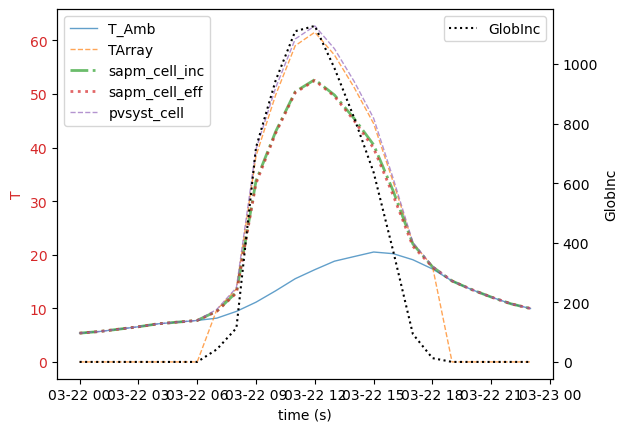

In [114]:
if run:
    # "TArray" = "TArrWtd ?
    
    pvs_slc_clms = ["T_Amb","TArray","sapm_cell_inc","sapm_cell_eff","pvsyst_cell"]
    
    linestyles = ["-","--","-.",":","--"]
    linewidths = [1,1,2,2,1]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('T', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=2)


    ax2_clmns = ["GlobInc"]
    # Io quite equal
    # ax2_clmns = ["dni_extra_"+method,"Io"]

    ax2 = ax1.twinx()  
    for c in ax2_clmns:
        ax2.plot(pvs_slc["datetime"],pvs_slc[c], label=c, color="k", linestyle=":")

    color = 'tab:blue'
    ax2.set_ylabel(ax2_clmns[0], color="k")  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor="k")
    ax2.legend(loc=1)

    plt.show()

    # for 0 irradiance PVsyst fail to reach ambient temperature
    # PVsyst modelling with fixed 0.1 efficiency different from PVsyst but less than using sapm 

In [115]:
run = False

### Analysis: IV_CURVES
Comparison IV curves with the ones in pvsyst.

In [116]:
if ("IV_CURVES" in ANALYSIS): run = True

#### Analysis: IV_CURVES - STC curves

Model not used since missing Adjust value
https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.calcparams_cec.html

In [117]:
type(1000) == int

True

In [ ]:
def plot_iv_curves(irradiance=[1000], temperature=[25],
    calcparamss = ["desoto", "pvsyst"], calccmps = ["singlediode", "bishop88"],
    methods = ["Lambertw"] # ["Lambertw", "newton", "brentq"]
    ) -> pd.DataFrame:
    # wrap up function
    # plotting parameters
    linestyles = ["-","--"]*len(methods) + ["-.",":"] # bishop use no methods
    linewidths = [1,1]*len(methods) + [1,1]
    # creating df
    iv_conditions = pd.DataFrame(columns=["TArray","GlobEff"])
    # need to provide arrays
    plt.close()
    fig,ax1 = plt.subplots()

    cnt = 0
    labels = []
    iv_curves = pd.DataFrame()

    if (len(irradiance)==1) & (len(temperature)==1):
        irradiance = irradiance[0]
        temperature = temperature [0]
        iv_conditions["GlobEff"] = [irradiance, irradiance]
        iv_conditions["TArray"] = [temperature, temperature]
        title = f"IV curves ({irradiance} W/m2 and {temperature} C°)"
        for p in calcparamss:
            for c in calccmps:
                if (c == "singlediode") & (len(methods) > 1):
                    for m in methods:
                        l = "_".join([p,c,m])
                        labels.append(l)
                        iv_curves_tmp = get_iv(iv_conditions, ps_prms, calcparams=p, calcmpp=c, method=m).iloc[0,:]           
                        iv_curves[l] = iv_curves_tmp
                        ax1.plot(iv_curves_tmp["v"], iv_curves_tmp["i"], label=l, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
                        cnt += 1
                else:
                    l = "_".join([p,c])
                    labels.append(l)
                    iv_curves_tmp = get_iv(iv_conditions, ps_prms, calcparams=p, calcmpp=c).iloc[0,:]           
                    iv_curves[l] = iv_curves_tmp
                    ax1.plot(iv_curves_tmp["v"], iv_curves_tmp["i"], label=l, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
                    cnt += 1

    elif (len(irradiance) == len(temperature)):
        calcparamss = calcparamss[0]
        calccmps = calccmps[0]
        methods = methods[0] 

        title = f"IV curves (parameters {calcparamss}, mpp {calccmps})"
        iv_conditions = pd.DataFrame({"GlobEff":irradiance,"TArray":temperature})
        iv_curves = get_iv(iv_conditions, ps_prms, calcparamss, calccmps, methods)         
        for k, r in iv_curves.iterrows():
            l = "_".join(["GlobEff",str(r["GlobEff"]),"TArray",str(r["TArray"])])
            ax1.plot(r["v"], r["i"], label=l, alpha=0.7)
      

    #for i,j in zip(x,y):
    #    ax1.annotate("stc_+"_"+";".join([str(round(i,1)),str(round(j,1))]),xy=(i,j))

    ax1.set_title(title)
    ax1.set_xlabel('v')
    ax1.set_ylabel('i')
    ax1.legend()
    return iv_curves

    

In [ ]:
ps_prms

{'alpha_sc': 0.0029,
 'gamma_ref': 0.94,
 'mu_gamma': -0.001,
 'I_L_ref': 8.64,
 'I_o_ref': 4.5999999999999996e-11,
 'R_sh_ref': 300,
 'R_sh_0': 1200,
 'R_s': 0.3,
 'cells_in_series': 60,
 'R_sh_exp': 5.5,
 'EgRef': 1.12,
 'irrad_ref': 1000,
 'temp_ref': 25}

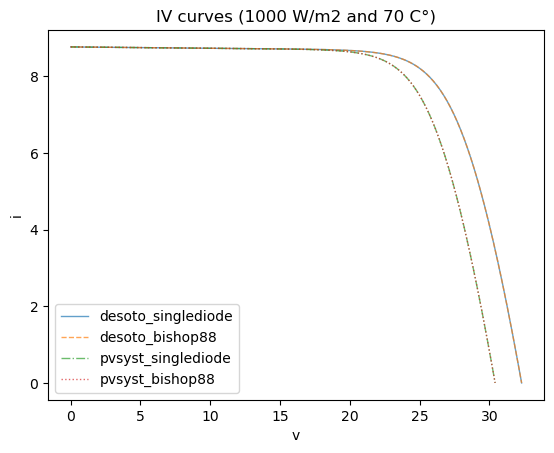

In [ ]:
iv_curves = plot_iv_curves([1000], [70])

In [ ]:
iv_curves

,desoto_singlediode,desoto_bishop88,pvsyst_singlediode,pvsyst_bishop88
TArray,70,70,70,70
GlobEff,1000,1000,1000,1000
photocurrent,8.7705,8.7705,8.7705,8.7705
saturation_current,0.0,0.0,0.0,0.0
resistance_series,0.3,0.3,0.3,0.3
resistance_shunt,300.0,300.0,300.0,300.0
nNsVth,1.668433,1.668433,1.587929,1.587929
i_sc,8.761738,8.761738,8.761738,8.761738
v_oc,32.312246,32.312246,30.413846,30.413846
i_mp,8.094936,8.094936,8.08614,8.08614


#### Analysis: IV_CURVES - all curves for one method

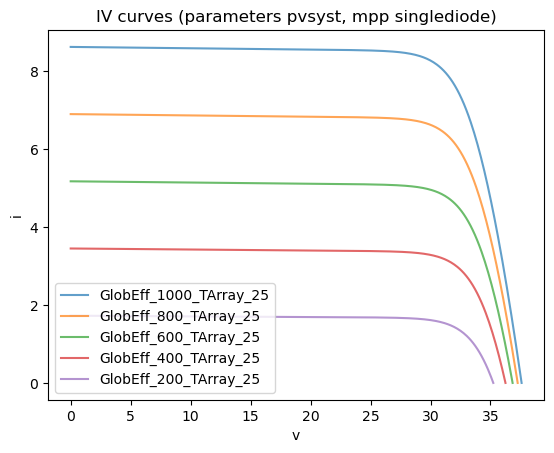

In [ ]:
iv_curves = plot_iv_curves(irradiance = [1000,800,600,400,200], temperature = [25]*5,
                            calcparamss=["pvsyst"], calccmps=["singlediode"], methods=["lambertw"])

In [ ]:
ps_prms

{'alpha_sc': 0.0029,
 'gamma_ref': 0.94,
 'mu_gamma': -0.001,
 'I_L_ref': 8.64,
 'I_o_ref': 4.5999999999999996e-11,
 'R_sh_ref': 300,
 'R_sh_0': 1200,
 'R_s': 0.3,
 'cells_in_series': 60,
 'R_sh_exp': 5.5,
 'EgRef': 1.12,
 'irrad_ref': 1000,
 'temp_ref': 25}

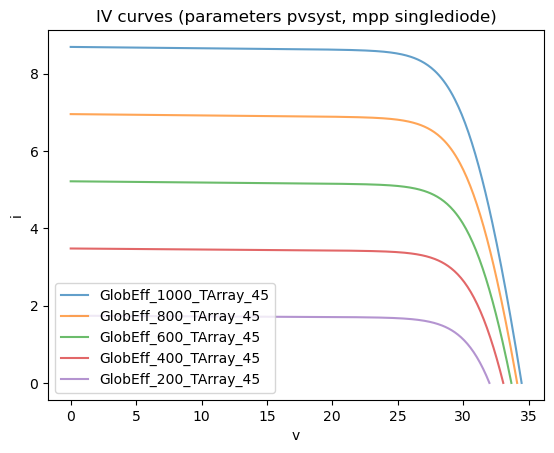

In [ ]:
iv_curves = plot_iv_curves(irradiance = [1000,800,600,400,200], temperature = [45]*5,
                            calcparamss=["pvsyst"], calccmps=["singlediode"], methods=["lambertw"])

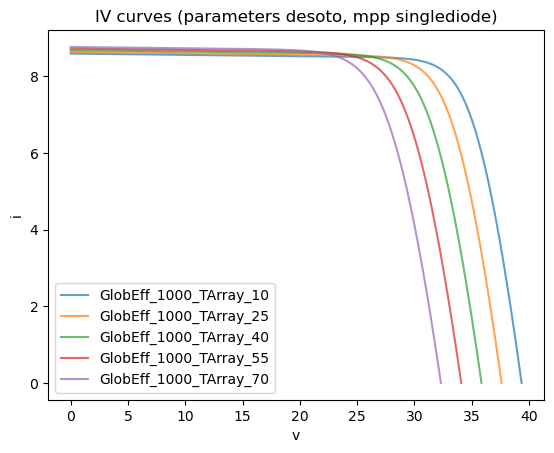

In [ ]:
iv_curves = plot_iv_curves(irradiance = [1000]*5, temperature = [10,25,40,55,70],
                            calcparamss=["desoto"], calccmps=["singlediode"], methods=["lambertw"])

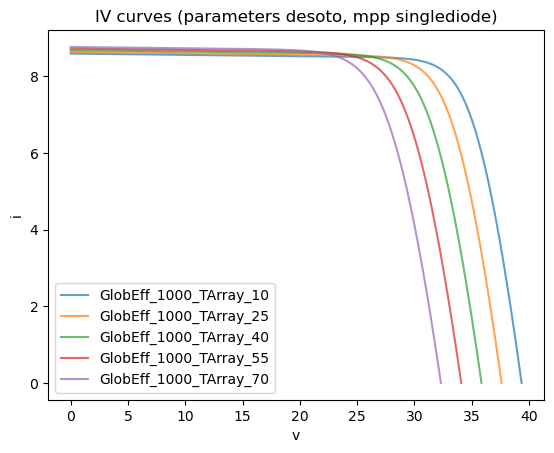

In [ ]:
iv_curves = plot_iv_curves(irradiance = [1000]*5, temperature = [10,25,40,55,70],
                            calcparamss=["desoto"], calccmps=["singlediode"], methods=["lambertw"])

#### Analysis: IV_CURVES - saving as files

In [ ]:
# iv_curves_ext[["i"+"{:03d}".format(n) for n in range(0,400)]] = pd.DataFrame(iv_curves_ext.i.tolist(), index = iv_curves_ext.index)
# iv_curves_ext[["v"+"{:03d}".format(n) for n in range(0,400)]] = pd.DataFrame(iv_curves_ext.v.tolist(), index = iv_curves_ext.index)

In [ ]:
# iv_curves.to_csv(r"C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\iv_curves.csv")

In [ ]:
# iv_curves_ext.to_csv(r"C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\iv_curves_ext.csv")

In [ ]:
# iv_curves_ext = copy.deepcopy(iv_curves)

iv_curves_ext.to_csv(r"C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\iv_curves_ext.csv")

### Analysis: IV

See also the "Output file parameters" in the pptx "PVsyst7_training_221027"

#### PVSYST
Navigation:  Physical models used > Standard one-diode-model
 
 To describe the operating of a PV module, we use the Shockley's simple "one diode" model, described, for example, in Beckman and al. This model is based on the following equivalent circuit for decribing a PV cvell: 

The main expression describing the general "one-diode" model for a given set of reference conditions  (usually STC: 1000 W/m2, 25°C, AM=1.5)  is written as: 

I  =  Iphref  -   IoRef  [ exp  (q · (V+I · Rs) / ( Ncs·Gamma·k·Tc) ) - 1 ]    -    (V + I · Rs) / Rsh

with :

I        =        Current supplied by the module  [A].

V        =        Voltage at the terminals of the module  [V].

IphRef        =        Photocurrent [A]

IoRef        =        diode inverse saturation current [A]

Rs        =        Series resistance [ohm].

Rsh        =        Shunt resistance [ohm].

Gamma=          Diode quality factor, theoretically between 1 and 2, often less

q        =        Charge of the electron  =  1.602·E-19 Coulomb

k        =        Bolzmann's constant   =  1.381 E-23  J/K.

Ncs        =        Number of cells in series.

Tc        =        Effective temperature of the cells  [Kelvin]

...

The one-diode model assumes that the photocurrent  Iph  is perfectly proportional to the irradiance

Iph =   ( G / Gref ) ·   [  Iph ref  +   muISC    (Tc   -  Tc ref) ]

where        

G and Gref          =         effective and reference irradiance [W/m²].

Tc and Tc ref        =        effective and reference cell's temperature [°K].

muISC                   =        temperature coefficient of the short-circuit current [A / °C]


##### PVSYST Array MPP "virtual" energy 

It applies the one-diode model for the module, and evaluates: 
- The MPP operating point of the array, calculated by the one-diode model if the system was running at STC efficiency  (1000 W/m² and 25°C). 
- The irradiance loss, i.e. the loss due to the low-light performances of the module.  
- The temperature loss due to the cell's temperature TArray.  
- The spectral loss if defined   (amorphous modules or Sandia model). 
- The electrical mismatch loss due to shadings   
- The module quality loss. 
- Eventually the LID loss if defined. 
- The Mismatch loss. 
- The Array wiring loss.  
This results in the  MPP virtually available energy EArrMPP. 
     

#### PVLIB single diode

**photocurrent**:numeric
Light-generated current (photocurrent) in amperes under desired IV curve conditions. Often abbreviated I_L. 0 <= photocurrent

IN PVSYST: IphRef 
**FM:using Isc**

**saturation_current**:numeric
Diode saturation current in amperes under desired IV curve conditions. Often abbreviated I_0. 0 < saturation_current

IN PVSYST: IoRef, diode inverse saturation current


**resistance_series**:numeric
Series resistance in ohms under desired IV curve conditions. Often abbreviated Rs. 0 <= resistance_series < numpy.inf

IN PVSYST =     

**resistance_shunt**:numeric
Shunt resistance in ohms under desired IV curve conditions. Often abbreviated Rsh. 0 < resistance_shunt <= numpy.inf

IN PVSYST =  

**nNsVth**:numeric
The product of three components. 

1) The usual diode ideal factor (n) IN PVSYST: Gamma=          Diode quality factor, theoretically between 1 and 2, often less

2) the number of cells in series (Ns)  IN PVSYST: Ncs

3) the cell thermal voltage under the desired IV curve conditions (Vth) = k*temp_cell/q

The thermal voltage of the cell (in volts) may be calculated as k*temp_cell/q, where k is Boltzmann’s constant (J/K), temp_cell is the temperature of the p-n junction in Kelvin, and q is the charge of an electron (coulombs). 

IN PVSYST: Vth = k * Tc / q


0 < nNsVth

**ivcurve_pnts**:None or int, default None
Number of points in the desired IV curve. If None or 0, no IV curves will be produced.

**method** :str, default ‘lambertw’
Determines the method used to calculate points on the IV curve. The options are 'lambertw', 'newton', or 'brentq'.


**Notes**

If the method is 'lambertw' then the solution employed to solve the implicit diode equation utilizes the Lambert W function to obtain an explicit function of V=f(I)
 and I=f(V)
 as shown in [2].

If the method is 'newton' then the root-finding Newton-Raphson method is used. It should be safe for well behaved IV-curves, but the 'brentq' method is recommended for reliability.

If the method is 'brentq' then Brent’s bisection search method is used that guarantees convergence by bounding the voltage between zero and open-circuit.

If the method is either 'newton' or 'brentq' and ivcurve_pnts are indicated, then pvlib.singlediode.bishop88() [4] is used to calculate the points on the IV curve points at diode voltages from zero to open-circuit voltage with a log spacing that gets closer as voltage increases. If the method is 'lambertw' then the calculated points on the IV curve are linearly spaced.

https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/singlediode.html

In [ ]:
if "IV" in ANALYSIS: run = True              

In [ ]:
pvs_slc = get_iv(pvs_slc, ps_prms, calcparams="desoto", calcmpp="singlediode", method="lambertw", ivcurve_pnts=400)

In [ ]:
run = True

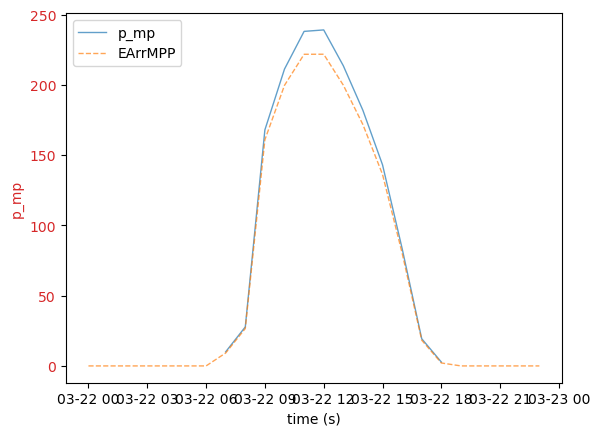

In [ ]:
if run:
  
    pvs_slc_clms = ["p_mp","EArrMPP"]
    
    linestyles = ["-","--"] #,"--"]
    linewidths = [1,1] #,2,1]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('p_mp', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=2)


    """ax2_clmns = ["EArrMPP"]
    # Array current  (taking inverter operating point displacements into account)
    # Io quite equal
    # ax2_clmns = ["dni_extra_"+method,"Io"]

    ax2 = ax1.twinx()  
    for c in ax2_clmns:
        ax2.plot(pvs_slc["datetime"],pvs_slc[c], label=c, color="k", linestyle=":")

    color = 'tab:blue'
    ax2.set_ylabel(ax2_clmns[0], color="k")  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor="k")
    ax2.legend(loc=1)"""

    plt.show()

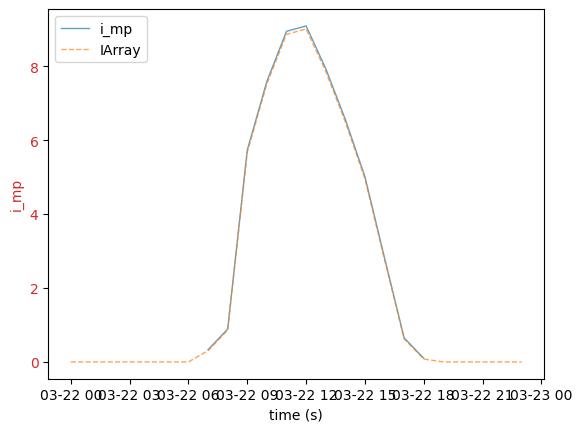

In [ ]:
if run:

    pvs_slc_clms = ["i_mp","IArray"]
    
    linestyles = ["-","--"] #,"--"]
    linewidths = [1,1] #,2,1]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('i_mp', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=2)


    """ax2_clmns = ["IArray"]
    # Array current  (taking inverter operating point displacements into account)
    # Io quite equal
    # ax2_clmns = ["dni_extra_"+method,"Io"]

    ax2 = ax1.twinx()  
    for c in ax2_clmns:
        ax2.plot(pvs_slc["datetime"],pvs_slc[c], label=c, color="k", linestyle=":")

    color = 'tab:blue'
    ax2.set_ylabel(ax2_clmns[0], color="k")  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor="k")
    ax2.legend(loc=1)"""

    plt.show()

In [ ]:
pvs_slc["GlobEff"].replace([0],[1000])
pvs_slc["TArray"].replace([0],[25])

1904    25.0000
1905    25.0000
1906    25.0000
1907    25.0000
1908    25.0000
1909    25.0000
1910    25.0000
1911     9.7395
1912    13.6210
1913    38.4340
1914    49.7990
1915    59.0190
1916    61.5310
1917    57.2820
1918    51.2490
1919    44.4760
1920    33.5590
1921    22.1710
1922    17.8410
1923    25.0000
1924    25.0000
1925    25.0000
1926    25.0000
1927    25.0000
Name: TArray, dtype: float64

In [ ]:
pvs_slc["TArray"]

1904     0.0000
1905     0.0000
1906     0.0000
1907     0.0000
1908     0.0000
1909     0.0000
1910     0.0000
1911     9.7395
1912    13.6210
1913    38.4340
1914    49.7990
1915    59.0190
1916    61.5310
1917    57.2820
1918    51.2490
1919    44.4760
1920    33.5590
1921    22.1710
1922    17.8410
1923     0.0000
1924     0.0000
1925     0.0000
1926     0.0000
1927     0.0000
Name: TArray, dtype: float64

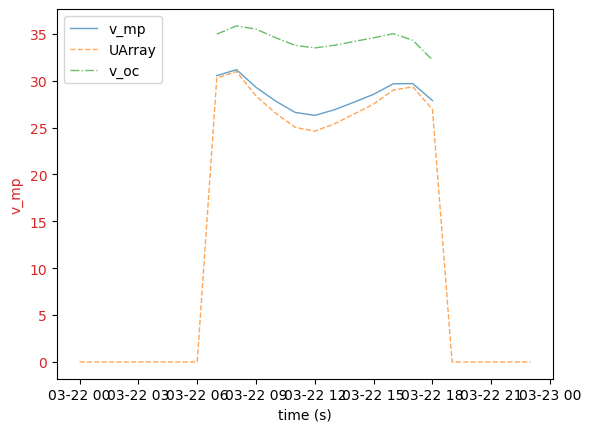

In [ ]:
if run:
  
    pvs_slc_clms = ["v_mp","UArray","v_oc"] #,"v_mp_bs_n",]
    
    linestyles = ["-","--","-."] #,"-"]
    linewidths = [1,1,1] #,1]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('v_mp', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=2)


    #ax2_clmns = ["UArray"]
    # Array voltage  (taking inverter operating point displacements into account)
    # Io quite equal
    # ax2_clmns = ["dni_extra_"+method,"Io"]

    """ax2 = ax1.twinx()  
    for c in ax2_clmns:
        ax2.plot(pvs_slc["datetime"],pvs_slc[c], label=c, color="k", linestyle=":")

    color = 'tab:blue'
    ax2.set_ylabel(ax2_clmns[0], color="k")  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor="k")
    ax2.legend(loc=1)"""

    plt.show()

In [ ]:
run = False

### Analysis: IV_PL

#### Sandia Model for PV modules
https://www.pvsyst.com/help/sandia_model.htm

The Sandia model for the modelling of PV Modules has been developed at the Sandia National Laboratories since 1992.
It is fully described in the report SAND2004-3535 (2004) directly available on the web.

The Sandia model doesn't describe a full I/V characteristics, but only 5 points on the I/V curve:   (0, Isc),  (Vmp/2, Ix),  (Vmp, Imp),  (Vmm, Ixx), and  (Voc, 0)    (where Vmm = (Voc + Vmpp)/2).

Therefore for using it in the simulation, Pvsyst has to complete the I/V curve.  For a given operating condition (G,T) we first calculate the 5 points from the Sandia model equations, and then we establish the one-diode model passing by these 5 points. 

The Sandia model defines a spectral correction, as a function of the Air mass only (no dependence of the Kt). Therefore we understand that this correction should be applied to the beam component only. The spectral balance (gain for crystalline, loss for amorphous) is reported on the loss diagram.

Comparisons with the one-diode model

When opening a module in the database of PVsyst, if an equivalent module is available in the Sandia database, this is referenced in the "Remarks" (and in the choice lists), and you have the opportunity choosing the model to be used.

-  On the "Additional Parameter" page, the parameters of the model are visualized, along with eventual differences with the PVsyst model. Here you can also choose a Sandia module to be associated to the module.

- The button  "Sandia-Diode compar" opens a window with a close comparison of the results of both models.

If the STC values are matching, you can ask for adjusting the One-diode parameters to match the Sandia model at best. You cans get the discrepancies between both models, either at 25°C, or for all temperature conditions.

#### Annex - Comments 26/3/23
In PVsyst Internal model result parameters (PmPP, Temper. coeff, Impp & Vmpp) already different when comparing Standard PVsyst vs Sandia model.
Furthermore sapm aoi loss & effective irradiance could be different as well:
https://pvlib-python.readthedocs.io/en/v0.4.3/_modules/pvlib/pvsystem.html#sapm


"lambert" or single method to be checked single _diode not working

https://pvlib-python.readthedocs.io/en/v0.6.0/_modules/pvlib/singlediode.html#bishop88

#### Annex - Photon Mag. 2005 + Sandia DB
Comparison between Sandia & PVsyst. Module areas don't match

#### Annex
The Sandia Laboratories have measured and characterized about 100 commercial PV modules up to 2004,  However to my knowing they did not publish any new data since about this date. These data are available in PVsyst.
FM ?!

https://forum.pvsyst.com/topic/2667-sandia-model-database-no-longer-supported/

In [ ]:
if "IV_PL" in ANALYSIS: run = True

if run:
        # columns for pvsyst
        clms_s = ["EArrMPP","EArray","IArray","UArray"]
        # original pvlib output
        clms = ["i_sc","v_oc","i_mp","v_mp","p_mp","i_x","i_xx"]
        clms_sapm = [c+"_pvl_sapm" for c in clms]
        clms_pv_prm = ["photocurrent","saturation_current","resistance_series","resistance_shunt","nNsVth"]
        clms_sd = [c+"_pvl_sd" for c in clms]
       

        # columns to change
        c = 0
        for f in PVSYST_HOURLY_FILES:
                # using the ones from pvsyst instead of pvlib
                temp_cell = "TArray"
                effective_irradiance = "GlobEff"                

                # merging
                if c == 0: 
                        pvs_slc = copy.deepcopy(pvs_slcs[f])
                        pvs_slc.rename(columns=dict(zip(clms_s,[c+sffs[f] for c in clms_s])), inplace=True)

                        if any([clms_pv_prm not in pvs_slc.columns.to_list()]):
                                pvs_slc[clms_pv_prm] = pvs_slc.apply(lambda x:                 
                                pvlib.pvsystem.calcparams_pvsyst(
                                effective_irradiance = x[effective_irradiance], 
                                temp_cell = x[temp_cell], 
                                alpha_sc = ps_prms["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
                                gamma_ref = ps_prms["gamma_ref"], #The diode ideality factor
                                mu_gamma = ps_prms["mu_gamma"], #The temperature coefficient for the diode ideality factor, 1/K
                                I_L_ref = ps_prms["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
                                I_o_ref = ps_prms["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
                                R_sh_ref = ps_prms["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
                                R_sh_0 = ps_prms["R_sh_0"], #The shunt resistance at zero irradiance conditions, in ohms.
                                R_s = ps_prms["R_s"], #The series resistance at reference conditions, in ohms.
                                cells_in_series = ps_prms["cells_in_series"], #The number of cells connected in series.
                                R_sh_exp=ps_prms["R_sh_exp"], #The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
                                EgRef=ps_prms["EgRef"], #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
                                irrad_ref=ps_prms["irrad_ref"], # Reference irradiance in W/m^2.
                                temp_ref=ps_prms["temp_ref"] # Reference cell temperature in C.
                                ) if x[effective_irradiance] != 0 else
                                pd.Series(dict(zip(clms_pv_prm,[np.nan]*len(clms_pv_prm)))), 
                                axis=1, result_type='expand')

                        if any([clms_sd not in pvs_slc.columns.to_list()]):
                                # unecessary same results regardless of the method
                                #for m in ['lambertw', 'newton', 'brentq']:
                                # The returned dict-like object always contains the keys/columns in clms
                                m = 'lambertw'
                                pvs_slc[clms] = pvs_slc.apply(lambda x:                 
                                pvlib.pvsystem.singlediode(
                                photocurrent = x["photocurrent"],
                                saturation_current = x["saturation_current"],
                                resistance_series = x["resistance_series"],
                                resistance_shunt = x["resistance_shunt"],
                                nNsVth = x["nNsVth"], # k_Boltzmann * x[temp_cell] / q_electron
                                ivcurve_pnts = 0,
                                method = m #, 'newton', or 'brentq'. # not defined for PVsyst?
                                ) if x[effective_irradiance] != 0 else
                                pd.Series(dict(zip(clms,[np.nan]*len(clms))))
                                , axis=1, result_type='expand')
                                # 19/3/23 value error maybe due to returning variable names, renaming after
                                pvs_slc.rename(columns=dict(zip(clms,clms_sd)), inplace=True)
               
                
                elif c > 0: 
                        if c == 1 & ("IV_SANDIA" in MODULE_ANALYSIS):
                                # sapm needed only once and only if minimum two files
                                # modelling with Sandia
                                if any([clms not in pvs_slc.columns.to_list()]):
                                        pvs_slc[clms] = pvs_slc.apply(lambda x:                 
                                        pvlib.pvsystem.sapm(x[effective_irradiance], x[temp_cell], module_parameters) if x[effective_irradiance] != 0 else
                                        pd.Series(dict(zip(clms,[np.nan]*len(clms))))
                                        , axis=1, result_type='expand')
                                        # rename after
                                        pvs_slc.rename(columns=dict(zip(clms,clms_sapm)), inplace=True)
                                        # pvs_slc["p_mp_pvl_sapm_kW"] = pvs_slc["p_mp_pvl_sapm"] / 1000     

                        pvs_slc = pvs_slc.merge(pvs_slcs[f][["datetime"]+clms_s], left_on="datetime", right_on="datetime")
                        # no need for suffix since already changed
                        pvs_slc.rename(columns=dict(zip(clms_s,[c+sffs[f] for c in clms_s])), inplace=True)
                        
                c += 1

In [ ]:
pvs_slc.columns.to_list()

['datetime',
 'GlobInc',
 'GlobEff',
 'EArrRef',
 'EArrMPP',
 'IArray',
 'UArray',
 'EArray',
 'EOutInv',
 'E_Grid',
 'Yr',
 'PR',
 'Lc',
 'EffInvR',
 'GlobHor',
 'DiffHor',
 'BeamHor',
 'HSol',
 'AzSol',
 'AngInc',
 'AngProf',
 'BeamTrp',
 'DifITrp',
 'CircTrp',
 'HBndTrp',
 'AlbTrp',
 'GlobTrp',
 'GincThr',
 'DifSInc',
 'Alb_Inc',
 'CircInc',
 'T_Amb',
 'WindVel',
 'TArray',
 'TArrWtd',
 'DTArr',
 'DTArrGl',
 'EffArrR',
 'EffArrC',
 'EffSysR',
 'EffSysC',
 'BeamNor',
 'GlPMeas',
 'GlobInc (Hay model)',
 'KT',
 'Io_sin_Hsol',
 'g_cmp11_ppuk',
 'year',
 'date',
 'hour',
 'photocurrent',
 'saturation_current',
 'resistance_series',
 'resistance_shunt',
 'nNsVth',
 'i_sc_pvl_sd',
 'v_oc_pvl_sd',
 'i_mp_pvl_sd',
 'v_mp_pvl_sd',
 'p_mp_pvl_sd',
 'i_x_pvl_sd',
 'i_xx_pvl_sd']

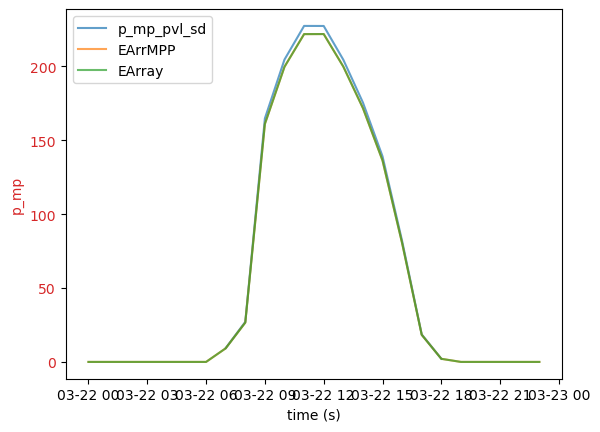

In [ ]:
if run:
    pvs_slc_clms = [c for c in pvs_slc.columns.to_list() if "p_mp" in c]
    
    for c in [l for l in pvs_slc.columns.to_list() if "EArrMPP" in l]:
        # 26/3/23 not needed if PVsyst output in W
        # pvs_slc[c+"_W"] = pvs_slc[c]*1000/1
        # pvs_slc_clms += [c+"_W"]
        pvs_slc_clms += [c]
    
    pvs_slc_clms += ["EArray"]

    #linestyles = ["-","--","-."] #,":","--"]
    #linewidths = [2,2,1] #,2,2,1]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7)
                 #,linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('p_mp', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=2)


    """ax2_clmns = ["EArrMPP"]
    # Array current  (taking inverter operating point displacements into account)
    # Io quite equal
    # ax2_clmns = ["dni_extra_"+method,"Io"]

    ax2 = ax1.twinx()  
    for c in ax2_clmns:
        ax2.plot(pvs_slc["datetime"],pvs_slc[c], label=c, color="k", linestyle=":")

    color = 'tab:blue'
    ax2.set_ylabel(ax2_clmns[0], color="k")  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor="k")
    ax2.legend(loc=1)

    plt.show()"""

Difference seems to come from voltage part

In [ ]:
pvs_slc["i_d"] = pvs_slc.apply(lambda x: 1-x["EArrMPP"]/x["p_mp_pvl_sd"] if x["p_mp_pvl_sd"] != 0 else 0, axis=1)
pvs_slc[["EArrMPP","p_mp_pvl_sd","i_d"]]

,EArrMPP,p_mp_pvl_sd,i_d
1904,0.0000,NaN,NaN
1905,0.0000,NaN,NaN
1906,0.0000,NaN,NaN
1907,0.0000,NaN,NaN
1908,0.0000,NaN,NaN
1909,0.0000,NaN,NaN
1910,0.0000,NaN,NaN
1911,9.2001,9.367429,0.017863
1912,26.6170,27.116029,0.018403
1913,161.0400,164.781856,0.022708


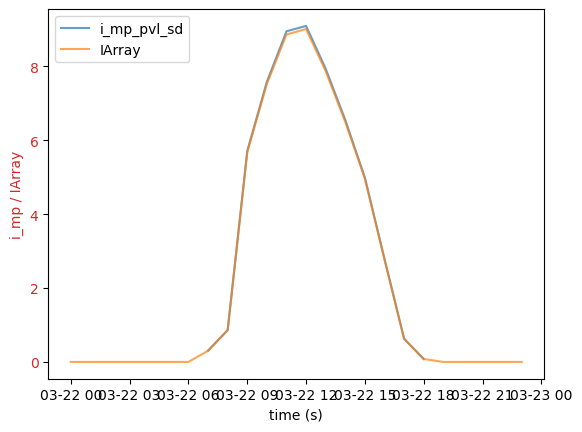

In [ ]:
if run:
    pvs_slc_clms = [c for c in pvs_slc.columns.to_list() if ("i_mp" in c)] 
    # separated to keep same order as before
    pvs_slc_clms += [c for c in pvs_slc.columns.to_list() if ("IArray" in c)]    
    #linestyles = ["-","--","-."] #,":","--"]
    #linewidths = [2,2,1] #,2,2,1]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7)
                 #,linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('i_mp / IArray', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=2)


In [ ]:
pvs_slc["i_d"] = pvs_slc.apply(lambda x: 1-x["IArray"]/x["i_mp_pvl_sd"] if x["i_mp_pvl_sd"] != 0 else 0, axis=1)
pvs_slc[pvs_slc_clms+["i_d"]]


,i_mp_pvl_sd,IArray,i_d
1904,NaN,0.0000,NaN
1905,NaN,0.0000,NaN
1906,NaN,0.0000,NaN
1907,NaN,0.0000,NaN
1908,NaN,0.0000,NaN
1909,NaN,0.0000,NaN
1910,NaN,0.0000,NaN
1911,0.30504546389970727,0.3037,0.004411
1912,0.8633453048826686,0.8591,0.004917
1913,5.713483395704154,5.6744,0.006841


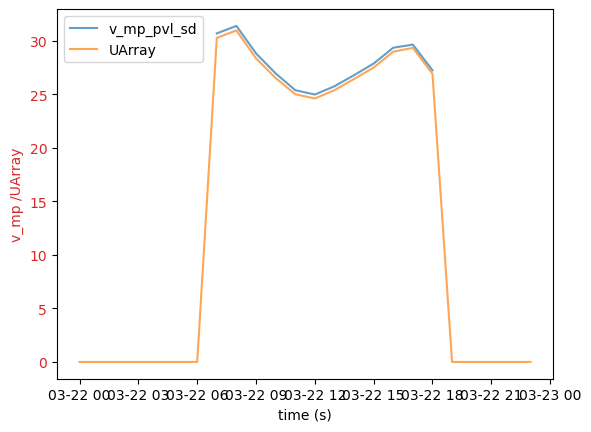

In [ ]:
if run:
    pvs_slc_clms = [c for c in pvs_slc.columns.to_list() if ("v_mp" in c)] 
    # separated to keep same order as before
    pvs_slc_clms += [c for c in pvs_slc.columns.to_list() if ("UArray" in c)]    
    #linestyles = ["-","--","-."] #,":","--"]
    #linewidths = [2,2,1] #,2,2,1]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7)
                 #,linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('v_mp /UArray', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=2)


In [ ]:
pvs_slc["v_d"] = pvs_slc.apply(lambda x: 1-x["UArray"]/x["v_mp_pvl_sd"] if x["v_mp_pvl_sd"] != 0 else 0, axis=1)
pvs_slc[["UArray","v_mp_pvl_sd","v_d"]]

,UArray,v_mp_pvl_sd,v_d
1904,0.000,NaN,NaN
1905,0.000,NaN,NaN
1906,0.000,NaN,NaN
1907,0.000,NaN,NaN
1908,0.000,NaN,NaN
1909,0.000,NaN,NaN
1910,0.000,NaN,NaN
1911,30.293,29.840157121552334,-0.015176
1912,30.984,30.71454051973924,-0.008773
1913,28.380,29.80160923881255,0.047702


In [ ]:
"""pvs_slc_a = copy.deepcopy(pvs_slc)
pvs_slc_a = pvs_slc_a[clms_sapm+[c for c in pvs_slc.columns.to_list() if "_pvs_snd" in c]]
pvs_slc_a.reindex(sorted(pvs_slc_a.columns), axis=1)"""
pvs_slc[[""]]


KeyError: "None of [Index([''], dtype='object')] are in the [columns]"

### Archived

In [ ]:
d = {}
for k in module_parameters.keys().to_list():
    d[k] = module_parameters[k]

for k, i in d.items():
    print(k, i)

Vintage 2009 (E)
Area 1.286
Material c-Si
Cells_in_Series 72
Parallel_Strings 1
Isco 5.3
Voco 44.4
Impo 4.89
Vmpo 35.8
Aisc 0.000624
Aimp -2.7e-05
C0 1.0016
C1 -0.0016
Bvoco -0.1646
Mbvoc 0
Bvmpo -0.1722
Mbvmp 0
N 1.274
C2 0.236148
C3 -4.62278
A0 0.9315
A1 0.0597
A2 -0.0107
A3 0.0008
A4 -2e-05
B0 1
B1 -0.002438
B2 0.0003103
B3 -1.246e-05
B4 2.11e-07
B5 -1.36e-09
DTC 3.0
FD 1
A -3.319
B -0.09116
C4 0.9908
C5 0.0092
IXO 5.303
IXXO 3.74
C6 1.1233
C7 -0.1233
Notes Source: Sandia National Laboratories Updated 9/25/2012 Module Database


In [ ]:
i_mp_input = ['Impo','C0','C1','Aimp']
v_mp_input = ['Vmpo','C2',"Cells_in_Series","C3"]
other_input = ['N','Bvmpo','Mbvmp']
i = i_mp_input+v_mp_input+other_input

d = {}
for k in i:
    d[k] = module_parameters[k]

for k, i in d.items():
    print(k, i)

T0 = 25

Impo 7.6921
C0 1.0158
C1 -0.0158
Aimp -0.0001
Vmpo 28.348
C2 -0.09677
Cells_in_Series 60
C3 -8.511484
N 1.226
Bvmpo -0.1449
Mbvmp 0


check deprecated functions:
https://pvlib-python.readthedocs.io/en/v0.9.4/_modules/pvlib/pvsystem.html

In [ ]:
T0 = 25
q = 1.60218 / (10**19)  # Elementary charge in units of coulombs
kb = 1.38066 / (10**23)  # Boltzmann's constant in units of J/K

In [ ]:

pvs_slc["i_mp_sapm"] = pvs_slc.apply(lambda x: 
                                     (d['Impo'] * (d['C0']*x[effective_irradiance] + d['C1']*(x[effective_irradiance]**2)) *
                                    (1 + d['Aimp']*(x[temp_cell] - T0))),
                                    axis = 1)                               
                                     
                                     
                                     

In [ ]:
pvs_slc["delta"] = pvs_slc.apply(lambda x: 
                                    d['N'] * kb * (x[temp_cell] + 273.15) / q,
                                    axis = 1)

pvs_slc["Bvmpo"] = pvs_slc.apply(lambda x: 
                                    d['Bvmpo'] + d['Mbvmp']*(1 - x[effective_irradiance]),
                                    axis = 1)


pvs_slc["v_mp_sapm"] = pvs_slc.apply(lambda x: 
                                     np.maximum(0, (
                                    d['Vmpo'] +
                                    d['C2'] * d['Cells_in_Series']*x["delta"] * np.log(x[effective_irradiance]) +
                                    d['C3'] * d['Cells_in_Series']*((x["delta"] * np.log(x[effective_irradiance])) ** 2) +
                                    x["Bvmpo"] * (x[temp_cell] - T0))) if x[effective_irradiance] != 0 else np.NaN,                                  
                                    axis = 1)

In [ ]:
pvs_slc[["i_mp_sapm","v_mp_sapm",effective_irradiance,temp_cell]]

,i_mp_sapm,v_mp_sapm,GlobEff,TArray
1904,0.000000,NaN,0.000,0.0000
1905,0.000000,NaN,0.000,0.0000
1906,0.000000,NaN,0.000,0.0000
1907,0.000000,NaN,0.000,0.0000
1908,0.000000,NaN,0.000,0.0000
1909,0.000000,NaN,0.000,0.0000
1910,0.000000,NaN,0.000,0.0000
1911,117.835172,23.696126,40.224,9.7175
1912,-590.146997,18.869847,108.850,13.5800
1913,-55434.946982,1.327153,708.730,38.3670


In [ ]:
pvs_slc[["p_mp_sapm_kW","EArrMPP","EArray","GlobEff","TArray","v_mp_sapm","UArray","i_mp_sapm","IArray"]]

,p_mp_sapm_kW,EArrMPP,EArray,GlobEff,TArray,v_mp_sapm,UArray,i_mp_sapm,IArray
1904,NaN,0.0000,0.0000,0.000,0.0000,NaN,0.00,0.000000,0.0000
1905,NaN,0.0000,0.0000,0.000,0.0000,NaN,0.00,0.000000,0.0000
1906,NaN,0.0000,0.0000,0.000,0.0000,NaN,0.00,0.000000,0.0000
1907,NaN,0.0000,0.0000,0.000,0.0000,NaN,0.00,0.000000,0.0000
1908,NaN,0.0000,0.0000,0.000,0.0000,NaN,0.00,0.000000,0.0000
1909,NaN,0.0000,0.0000,0.000,0.0000,NaN,0.00,0.000000,0.0000
1910,NaN,0.0000,0.0000,0.000,0.0000,NaN,0.00,0.000000,0.0000
1911,0.008308,0.0935,0.0935,40.224,9.7175,23.696126,299.83,117.835172,0.3119
1912,0.023876,0.2664,0.2664,108.850,13.5800,18.869847,306.92,-590.146997,0.8681
1913,0.144454,1.6480,1.6480,708.730,38.3670,1.327153,286.62,-55434.946982,5.7497


In [ ]:
[c for c in pvs_slc.columns.to_list() if "rray" in c]

['IArray', 'UArray', 'EArray', 'TArray']

In [ ]:
pvs_slc[["p_mp_sapm","p_mp","EArrMPP","EArray","i_mp_sapm","i_mp","IArray","v_mp_sapm","v_mp","UArray"]]

,p_mp_sapm,p_mp,EArrMPP,EArray,i_mp_sapm,i_mp,IArray,v_mp_sapm,v_mp,UArray
1904,NaN,NaN,0.0000,0.0000,0.000000,NaN,0.0000,NaN,NaN,0.00
1905,NaN,NaN,0.0000,0.0000,0.000000,NaN,0.0000,NaN,NaN,0.00
1906,NaN,NaN,0.0000,0.0000,0.000000,NaN,0.0000,NaN,NaN,0.00
1907,NaN,NaN,0.0000,0.0000,0.000000,NaN,0.0000,NaN,NaN,0.00
1908,NaN,NaN,0.0000,0.0000,0.000000,NaN,0.0000,NaN,NaN,0.00
1909,NaN,NaN,0.0000,0.0000,0.000000,NaN,0.0000,NaN,NaN,0.00
1910,NaN,NaN,0.0000,0.0000,0.000000,NaN,0.0000,NaN,NaN,0.00
1911,8.308256,8.951617,0.0935,0.0935,117.835172,0.295287975032782,0.3119,23.696126,30.314870995025945,299.83
1912,23.875881,25.971501,0.2664,0.2664,-590.146997,0.8357737380795438,0.8681,18.869847,31.074799518656196,306.92
1913,144.453946,133.141986,1.6480,1.6480,-55434.946982,4.627095449075694,5.7497,1.327153,28.774419644880386,286.62


In [ ]:
if run:
    pvs_slc_clms = ["GlobInc (Hay model)",'GlobTrp','GlobInc']
    linestyles = ["-","--","-."]
    linewidths = [1,1,2]

    #pvs["DifI_CircT_Trp"] = pvs["DifITrp"]+pvs["CircTrp"]

    fig,ax1 = plt.subplots()
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py

    cnt = 0
    for c in pvs_slc_clms:
        ax1.plot(pvs_slc["datetime"],pvs_slc[c], label=c, alpha=0.7, linestyle=linestyles[cnt], linewidth=linewidths[cnt])
        cnt += 1
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('GlobInc', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
     
    plt.show()

#### Tilt and azimuth

In [ ]:
# TBU
module_parameters = {'pdc0': 5000, 'gamma_pdc': -0.004}

mount = pvsystem.FixedMount(surface_tilt=SURFACE_TILT, surface_azimuth=pvl_azm_from_pvs(SURFACE_AZIMUTH),
racking_model=None, module_height=None)

array_one = pvsystem.Array(mount=mount, module_parameters=module_parameters)

system = pvsystem.PVSystem(arrays=[array_one])

#### Module and inverter parameters

In [ ]:
        """
        no inverted needed
        ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
        annual_energy = ac.sum()"""
# modules = pvsystem.retrieve_sam('cecmod')

In [ ]:
[c for c in modules.columns if "SolarWorld" in c and "245" in c]

['SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_245_mono',
 'SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_245_mono_black',
 'SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_245_poly']

In [ ]:
# Load the database of CEC module model parameters
modules = pvsystem.retrieve_sam('cecmod')

# retrieve_sam returns a dict. the dict keys are module names,
# and the values are model parameters for that module
module_parameters = modules['SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_245_poly']

# 7/1/23 inverter should no matter if virtual energy
# Load the database of CEC inverter model parameters
inverters = pvsystem.retrieve_sam('cecinverter')

inverter_parameters = inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

# 7/1/23 added
array_one = pvsystem.Array(mount=mount, module_parameters=module_parameters)
# 7/1/23 added
system_one_array = pvsystem.PVSystem(arrays=[array_one], module_parameters=module_parameters,
                                     inverter_parameters=inverter_parameters)

#### Module strings

In [ ]:
data = pd.DataFrame({'v_mp': 8, 'v_oc': 10, 'i_mp': 5, 'i_x': 6,
                     'i_xx': 4, 'i_sc': 7, 'p_mp': 40}, index=[0])

data_scaled = system_one_array.scale_voltage_current_power(data)

# 7/1/23 same values, no scaling, since single module single array
print(data_scaled)

   v_mp  v_oc  i_mp  i_x  i_xx  i_sc  p_mp
0     8    10     5    6     4     7    40


#### Losses
The losses_parameters attribute contains data that may be used with methods that calculate system losses. At present, these methods include only pvlib.pvsystem.PVSystem.pvwatts_losses() and pvlib.pvsystem.pvwatts_losses(), but we hope to add more related functions and methods in the future.

In [ ]:
test = False
"""def fit_sdm_desoto(v_mp, i_mp, v_oc, i_sc, alpha_sc, beta_voc,
                   cells_in_series, EgRef=1.121, dEgdT=-0.0002677,
                   temp_ref=25, irrad_ref=1000, root_kwargs={})"""

'def fit_sdm_desoto(v_mp, i_mp, v_oc, i_sc, alpha_sc, beta_voc,\n                   cells_in_series, EgRef=1.121, dEgdT=-0.0002677,\n                   temp_ref=25, irrad_ref=1000, root_kwargs={})'